In [1]:
import sys
sys.path.append("/home/vblot/multiaccurate_cp/")

In [2]:
sys.path

['/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/home/vblot/multiaccurate_cp/.venv/lib/python3.10/site-packages',
 '/home/vblot/multiaccurate_cp/']

In [3]:
import os
import yaml

import cv2
import numpy as np
import matplotlib.pyplot as plt
from mapie.multi_label_classification import MapieMultiLabelClassifier
from scipy import integrate
from scipy.optimize import minimize
from tqdm import tqdm

from multiaccurate_cp.utils.multiaccurate import J, J_prime

%load_ext autoreload
%autoreload 2

In [4]:
BASE_DIR = "/home/vblot/multiaccurate_cp/data/polyp"
MODELS_PATH = "/home/vblot/multiaccurate_cp/data/polyp/03_model_weights/resnet"
MODEL_NAME = "20240325_1446"

In [5]:
# Specify the path to the YAML file
file_path = os.path.join(MODELS_PATH, MODEL_NAME, "config.yaml")

# Read the YAML file
with open(file_path, "r") as file:
    config = yaml.safe_load(file)


In [6]:
IMG_SIZE = 64
RESNET_EMBEDDING_SIZE = config["model"]["embedding_size"]


In [7]:
DIR_CAL_PRED_PROBAS = os.path.join(BASE_DIR, "04_predictions/cal/pred_probas")
DIR_CAL_LABELS = os.path.join(BASE_DIR, "02_prepared_data/cal/labels")
DIR_TEST_PRED_PROBAS = DIR_CAL_PRED_PROBAS.replace("cal", "test")
DIR_TEST_LABELS = DIR_CAL_LABELS.replace("cal", "test")

DIR_CAL_RES_EMB = os.path.join(BASE_DIR, "04_predictions/cal/res_embeddings", MODEL_NAME)
DIR_TEST_RES_EMB = DIR_CAL_RES_EMB.replace("cal", "test")




In [8]:
def load_data(pred_probas_dir, res_emb_dir, labels_dir):
    pred_probas = np.zeros((len(os.listdir(pred_probas_dir)), IMG_SIZE, IMG_SIZE))
    res_emb = np.zeros((len(os.listdir(res_emb_dir)), RESNET_EMBEDDING_SIZE))
    labels = np.zeros((len(os.listdir(labels_dir)), IMG_SIZE, IMG_SIZE))

    for i, (pred_proba_file, res_emb_file, label_file) in enumerate(
        tqdm(zip(
            sorted(os.listdir(pred_probas_dir)),
            sorted(os.listdir(res_emb_dir)),
            sorted(os.listdir(labels_dir))
        ))
    ):
        pred_proba = np.load(os.path.join(pred_probas_dir, pred_proba_file))
        pred_probas[i] = cv2.resize(pred_proba, (IMG_SIZE, IMG_SIZE))
        res_emb[i] = np.load(os.path.join(res_emb_dir, res_emb_file))
        label = cv2.imread(os.path.join(labels_dir, label_file), cv2.IMREAD_GRAYSCALE) / 255
        labels[i] = cv2.resize(label, (IMG_SIZE, IMG_SIZE)) > .5    
    return pred_probas, res_emb, labels


In [9]:
load_cal_pred_probas, load_cal_res_emb, load_cal_labels = load_data(
    DIR_CAL_PRED_PROBAS, DIR_CAL_RES_EMB, DIR_CAL_LABELS
)


0it [00:00, ?it/s]

84it [00:00, 831.50it/s]

168it [00:00, 400.66it/s]

220it [00:00, 347.44it/s]

252it [00:00, 410.72it/s]

In [10]:
load_test_pred_probas, load_test_res_emb, load_test_labels = load_data(
    DIR_TEST_PRED_PROBAS, DIR_TEST_RES_EMB, DIR_TEST_LABELS
)

0it [00:00, ?it/s]

147it [00:00, 1467.50it/s]

294it [00:00, 1374.37it/s]

432it [00:00, 495.67it/s] 

520it [00:00, 444.30it/s]

546it [00:00, 550.96it/s]

In [11]:
all_pred_probas = np.concatenate([load_cal_pred_probas, load_test_pred_probas])
all_res_emb = np.concatenate([load_cal_res_emb, load_test_res_emb])
all_labels = np.concatenate([load_cal_labels, load_test_labels])


In [12]:
ALPHA = .1
REGULARIZATION = "ridge"

In [13]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = 1

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        return pred_proba >= .5

    def __sklearn_is_fitted__(self):
        return True

In [14]:
def grid_search_lambda(labels, pred_probas, embeddings, embedding_size):
    lambdas = [0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 1]
    best_dist = np.inf
    best_lambda = None
    cv = len(lambdas)
    # get cv indices
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    indices = np.array_split(indices, cv)
    for i, lambda_ in enumerate(tqdm(lambdas)):
        test_labels = labels[indices[i]]
        test_pred_probas = pred_probas[indices[i]]
        test_res_emb = embeddings[indices[i]]
        cal_labels = np.concatenate([labels[indices[j]] for j in range(cv) if j != i])
        cal_pred_probas = np.concatenate([pred_probas[indices[j]] for j in range(cv) if j != i])
        cal_res_emb = np.concatenate([embeddings[indices[j]] for j in range(cv) if j != i])
        
        result = minimize(
            J, np.random.uniform(0, 1, embedding_size),
            method="SLSQP",
            args=(cal_labels, cal_pred_probas, cal_res_emb, ALPHA, len(cal_labels), REGULARIZATION, lambda_), jac=J_prime,
            options={"disp": False, "maxiter": 10000}
        )
        ths = np.maximum((test_res_emb @ result.x).reshape(-1, 1, 1), 0.01)
        ths = (test_res_emb @ result.x).reshape(-1, 1, 1)
        test_res_emb.shape
        y_pred_test_th = (test_pred_probas >= ths).astype(int)
        recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))
        if (np.abs(recall_test - (1 - ALPHA))) < best_dist:
            best_dist = np.abs(recall_test - (1 - ALPHA))
            best_lambda = lambda_
        
    return best_lambda, best_dist
        

# Cross validation

In [15]:
recalls_crc = []
recalls_resnet = []

precisions_crc = []
precisions_resnet = []

for _ in tqdm(range(100)):
    cal_inx = np.random.choice(range(len(all_pred_probas)), len(all_pred_probas) // 2 , replace=False)
    test_inx = np.array([i for i in range(len(all_pred_probas)) if i not in cal_inx])
    temp_cal_pred_probas = all_pred_probas[cal_inx]
    temp_cal_res_emb = all_res_emb[cal_inx]
    temp_cal_labels = all_labels[cal_inx]

    index_not_empy = np.where(temp_cal_labels.sum(axis=(1, 2)) > 0)[0]
    temp_cal_labels = temp_cal_labels[index_not_empy]
    temp_cal_res_emb = temp_cal_res_emb[index_not_empy]
    temp_cal_pred_probas = temp_cal_pred_probas[index_not_empy]

    temp_test_pred_probas = all_pred_probas[test_inx]
    temp_test_res_emb = all_res_emb[test_inx]
    temp_test_labels = all_labels[test_inx]

    # CRC
    mapie_crc = MapieMultiLabelClassifier(MapieWrapper(), method="crc")
    for i in tqdm(range(len(temp_cal_pred_probas))):
        X, y = temp_cal_pred_probas[i], temp_cal_labels[i]
        mapie_crc.partial_fit(X.ravel()[np.newaxis, :], y.ravel()[np.newaxis, :])
    _, _ = mapie_crc.predict(temp_test_pred_probas.ravel()[np.newaxis, :], alpha=ALPHA)
    th_crc = mapie_crc.lambdas_star

    # ResNet
    lambda_resnet, dist_resnet = grid_search_lambda(temp_cal_labels, temp_cal_pred_probas, temp_cal_res_emb, RESNET_EMBEDDING_SIZE)
    print(lambda_resnet, dist_resnet)
    result_res = minimize(
        J, np.random.uniform(0, 1, RESNET_EMBEDDING_SIZE),
        method="SLSQP",
        args=(temp_cal_labels, temp_cal_pred_probas, temp_cal_res_emb, ALPHA, len(temp_cal_labels), REGULARIZATION, lambda_resnet), jac=J_prime,
        options={"disp": True, "maxiter": 1000}, tol=1e-10
    )
    ths_res = (temp_test_res_emb @ result_res.x).reshape(-1, 1, 1)

    

    y_pred_test_th_crc = (temp_test_pred_probas >= th_crc).astype(int)
    y_pred_test_th_res = (temp_test_pred_probas >= ths_res).astype(int)

    recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
    recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))

    precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
    precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
    
    

  0%|                                                                                                                      | 0/100 [00:00<?, ?it/s]

  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 30%|████████████████████████████████▏                                                                         | 121/399 [00:00<00:00, 1204.68it/s]

 61%|████████████████████████████████████████████████████████████████▎                                         | 242/399 [00:00<00:00, 1196.72it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▏         | 362/399 [00:00<00:00, 1174.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 558.05it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:35<03:33, 35.58s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:52<02:03, 24.70s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:05<01:16, 19.09s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:15<00:46, 15.61s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:24<00:26, 13.38s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:35<00:12, 12.38s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:43<00:00, 10.95s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:43<00:00, 14.75s/it]

1 0.010456739233433932


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  1%|█                                                                                                          | 1/100 [02:07<3:29:58, 127.26s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770597217977924
            Iterations: 17
            Function evaluations: 43
            Gradient evaluations: 17


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 32%|█████████████████████████████████▋                                                                        | 127/399 [00:00<00:00, 1266.79it/s]

 64%|███████████████████████████████████████████████████████████████████▋                                      | 255/399 [00:00<00:00, 1270.41it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 383/399 [00:00<00:00, 1262.44it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1258.63it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:54<05:26, 54.45s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:12<02:44, 32.95s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:31<01:46, 26.67s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:45<01:05, 21.67s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:55<00:34, 17.45s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:07<00:15, 15.44s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:13<00:00, 12.55s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:13<00:00, 19.09s/it]

0.5 0.00262453952974373


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  2%|██▏                                                                                                        | 2/100 [04:39<3:52:00, 142.05s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77260197088223
            Iterations: 12
            Function evaluations: 30
            Gradient evaluations: 12


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 26%|███████████████████████████▎                                                                              | 103/399 [00:00<00:00, 1023.62it/s]

 57%|████████████████████████████████████████████████████████████▌                                             | 228/399 [00:00<00:00, 1153.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎              | 344/399 [00:00<00:00, 492.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 594.72it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:51<05:11, 51.84s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:12<02:47, 33.57s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:31<01:48, 27.08s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:46<01:06, 22.02s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:55<00:34, 17.25s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:03<00:14, 14.24s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:13<00:00, 12.94s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:13<00:00, 19.10s/it]

0.1 0.005045671619560821


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  3%|███▏                                                                                                       | 3/100 [07:17<4:01:33, 149.41s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.774631525428
            Iterations: 20
            Function evaluations: 38
            Gradient evaluations: 20


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

  9%|█████████▍                                                                                                  | 35/399 [00:00<00:01, 308.99it/s]

 17%|█████████████████▊                                                                                          | 66/399 [00:00<00:01, 201.69it/s]

 36%|██████████████████████████████████████                                                                     | 142/399 [00:00<00:00, 392.09it/s]

 66%|███████████████████████████████████████████████████████████████████████                                    | 265/399 [00:00<00:00, 665.51it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 342/399 [00:00<00:00, 661.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 572.52it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:47<04:43, 47.26s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:04<02:27, 29.48s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:16<01:26, 21.50s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:28<00:53, 17.99s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:36<00:28, 14.39s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:45<00:12, 12.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:53<00:00, 10.90s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:53<00:00, 16.18s/it]

0.1 0.015205860669558424


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  4%|████▎                                                                                                      | 4/100 [09:36<3:52:00, 145.00s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773847599452854
            Iterations: 21
            Function evaluations: 41
            Gradient evaluations: 21


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 27%|████████████████████████████▉                                                                             | 109/399 [00:00<00:00, 1088.79it/s]

 55%|██████████████████████████████████████████████████████████▍                                                | 218/399 [00:00<00:00, 944.06it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▋                 | 334/399 [00:00<00:00, 1034.14it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1051.73it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:43<04:19, 43.21s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:06<02:36, 31.28s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:20<01:34, 23.68s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:34<00:58, 19.64s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:41<00:30, 15.12s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:52<00:13, 13.92s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:02<00:00, 12.56s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:02<00:00, 17.53s/it]

1 0.003489613255662549


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  5%|█████▎                                                                                                     | 5/100 [11:59<3:48:42, 144.44s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770679954715998
            Iterations: 14
            Function evaluations: 32
            Gradient evaluations: 14


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                | 100/399 [00:00<00:00, 987.99it/s]

 50%|█████████████████████████████████████████████████████▎                                                     | 199/399 [00:00<00:00, 298.07it/s]

 69%|██████████████████████████████████████████████████████████████████████████                                 | 276/399 [00:00<00:00, 392.85it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 397/399 [00:00<00:00, 574.49it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 498.03it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:49<04:58, 49.74s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:05<02:27, 29.46s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:21<01:34, 23.65s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:36<00:59, 19.98s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:47<00:33, 16.79s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:54<00:13, 13.72s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:05<00:00, 12.78s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:05<00:00, 17.98s/it]

0.1 0.0010609608317274644


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  6%|██████▍                                                                                                    | 6/100 [14:23<3:46:14, 144.41s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773805728936424
            Iterations: 12
            Function evaluations: 29
            Gradient evaluations: 12


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 27%|████████████████████████████▏                                                                             | 106/399 [00:00<00:00, 1034.13it/s]

 53%|████████████████████████████████████████████████████████▎                                                  | 210/399 [00:00<00:00, 470.28it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                 | 273/399 [00:00<00:00, 443.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 649.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 596.77it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:46<04:41, 46.94s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:12<02:52, 34.57s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:31<01:49, 27.29s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:43<01:04, 21.39s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:52<00:33, 16.67s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:00<00:13, 13.84s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:07<00:00, 11.54s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:07<00:00, 18.18s/it]

0.1 0.006889808654316543


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  7%|███████▍                                                                                                   | 7/100 [16:54<3:46:52, 146.37s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77367272950352
            Iterations: 21
            Function evaluations: 41
            Gradient evaluations: 21


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 32%|█████████████████████████████████▍                                                                        | 126/399 [00:00<00:00, 1255.67it/s]

 64%|███████████████████████████████████████████████████████████████████▋                                      | 255/399 [00:00<00:00, 1270.94it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 383/399 [00:00<00:00, 1271.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1265.01it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:53<05:18, 53.01s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:08<02:35, 31.09s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:23<01:34, 23.53s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:36<00:57, 19.31s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:44<00:30, 15.41s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:56<00:14, 14.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:09<00:00, 13.74s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:09<00:00, 18.49s/it]

0.1 2.7442079633122063e-05


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  8%|████████▌                                                                                                  | 8/100 [20:40<4:23:10, 171.64s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773500107384876
            Iterations: 41
            Function evaluations: 142
            Gradient evaluations: 41


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 20%|█████████████████████▍                                                                                      | 79/399 [00:00<00:00, 771.25it/s]

 39%|██████████████████████████████████████████                                                                 | 157/399 [00:00<00:00, 281.03it/s]

 59%|███████████████████████████████████████████████████████████████▌                                           | 237/399 [00:00<00:00, 400.69it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 347/399 [00:00<00:00, 573.93it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 529.63it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:47<04:44, 47.37s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:05<02:31, 30.27s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:25<01:41, 25.40s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:42<01:06, 22.10s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:51<00:34, 17.31s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:03<00:15, 15.72s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:16<00:00, 14.59s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:16<00:00, 19.43s/it]

0.7 0.00023459968708272605


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
  9%|█████████▋                                                                                                 | 9/100 [23:17<4:13:34, 167.20s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.771445355262136
            Iterations: 13
            Function evaluations: 31
            Gradient evaluations: 13


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 16%|█████████████████▎                                                                                          | 64/399 [00:00<00:00, 616.22it/s]

 32%|█████████████████████████████████▊                                                                         | 126/399 [00:00<00:01, 205.55it/s]

 57%|████████████████████████████████████████████████████████████▊                                              | 227/399 [00:00<00:00, 378.49it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▋               | 342/399 [00:00<00:00, 553.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:01<00:00, 338.12it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:59<05:54, 59.04s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:22<03:10, 38.19s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:40<01:54, 28.72s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:54<01:09, 23.08s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:03<00:36, 18.07s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:10<00:14, 14.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:18<00:00, 12.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:18<00:00, 19.84s/it]

1 0.0003488505633094663


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 10%|██████████▌                                                                                               | 10/100 [25:56<4:06:58, 164.65s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770148390477692
            Iterations: 15
            Function evaluations: 34
            Gradient evaluations: 15


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 29%|███████████████████████████████                                                                           | 117/399 [00:00<00:00, 1164.66it/s]

 59%|██████████████████████████████████████████████████████████████▋                                           | 236/399 [00:00<00:00, 1178.43it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████           | 358/399 [00:00<00:00, 1196.08it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1193.16it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:50<05:00, 50.13s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:10<02:42, 32.42s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:27<01:42, 25.71s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:39<00:59, 19.96s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:51<00:34, 17.14s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:03<00:15, 15.49s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:12<00:00, 13.26s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:12<00:00, 18.88s/it]

1 0.006896053574814154


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 11%|███████████▋                                                                                              | 11/100 [28:26<3:57:32, 160.14s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770385328345652
            Iterations: 11
            Function evaluations: 30
            Gradient evaluations: 11


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 30%|███████████████████████████████▌                                                                          | 119/399 [00:00<00:00, 1184.91it/s]

 60%|███████████████████████████████████████████████████████████████▍                                          | 239/399 [00:00<00:00, 1189.59it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████           | 358/399 [00:00<00:00, 619.18it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 709.59it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:43<04:19, 43.20s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:06<02:38, 31.64s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:23<01:38, 24.67s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:37<01:02, 20.68s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:47<00:33, 16.80s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:58<00:14, 14.67s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:08<00:00, 13.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:08<00:00, 18.30s/it]

0.1 0.009945350833291955


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 12%|████████████▋                                                                                             | 12/100 [32:24<4:29:38, 183.84s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.774049877439547
            Iterations: 41
            Function evaluations: 146
            Gradient evaluations: 41


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 16%|█████████████████▌                                                                                          | 65/399 [00:00<00:00, 647.97it/s]

 36%|██████████████████████████████████████▉                                                                    | 145/399 [00:00<00:00, 734.53it/s]

 55%|██████████████████████████████████████████████████████████▋                                                | 219/399 [00:00<00:00, 278.93it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▍                          | 300/399 [00:00<00:00, 383.41it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 363/399 [00:00<00:00, 428.63it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 408.10it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:53<05:18, 53.00s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:29<03:35, 43.13s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:51<02:13, 33.40s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:06<01:18, 26.18s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:15<00:40, 20.28s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:25<00:16, 16.72s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:37<00:00, 14.97s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:37<00:00, 22.45s/it]

0.7 0.015475256588898367


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 13%|█████████████▊                                                                                            | 13/100 [35:21<4:23:33, 181.76s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.771570892267535
            Iterations: 11
            Function evaluations: 25
            Gradient evaluations: 11


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

  9%|█████████▍                                                                                                  | 35/399 [00:00<00:01, 348.39it/s]

 27%|████████████████████████████▍                                                                              | 106/399 [00:00<00:00, 559.56it/s]

 54%|█████████████████████████████████████████████████████████▋                                                 | 215/399 [00:00<00:00, 800.21it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▉                           | 298/399 [00:00<00:00, 809.72it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 379/399 [00:00<00:00, 802.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 758.02it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:44<04:26, 44.40s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:11<02:51, 34.39s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:33<01:55, 28.82s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:47<01:08, 22.98s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:56<00:35, 17.81s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:07<00:15, 15.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:16<00:00, 13.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:16<00:00, 19.49s/it]

0.2 0.007722814862970551


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 14%|██████████████▊                                                                                           | 14/100 [38:42<4:28:52, 187.59s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773696389972004
            Iterations: 27
            Function evaluations: 82
            Gradient evaluations: 27


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

  2%|█▋                                                                                                            | 6/399 [00:00<00:07, 56.01it/s]

  3%|███▎                                                                                                         | 12/399 [00:00<00:07, 48.40it/s]

 11%|███████████▎                                                                                                | 42/399 [00:00<00:02, 149.80it/s]

 29%|███████████████████████████████                                                                            | 116/399 [00:00<00:00, 365.07it/s]

 58%|██████████████████████████████████████████████████████████████▍                                            | 233/399 [00:00<00:00, 640.47it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▏            | 351/399 [00:00<00:00, 817.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 580.24it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:55<05:30, 55.01s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:20<03:07, 37.57s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:38<01:54, 28.64s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:01<01:19, 26.61s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:10<00:40, 20.15s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:28<00:19, 19.51s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:41<00:00, 17.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:41<00:00, 23.01s/it]

0.5 0.004270503932544578


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 15%|███████████████▉                                                                                          | 15/100 [41:44<4:23:27, 185.97s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.772781834369555
            Iterations: 10
            Function evaluations: 25
            Gradient evaluations: 10


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 13%|█████████████▊                                                                                              | 51/399 [00:00<00:00, 477.26it/s]

 26%|███████████████████████████▉                                                                               | 104/399 [00:00<00:00, 507.23it/s]

 51%|██████████████████████████████████████████████████████▏                                                    | 202/399 [00:00<00:00, 718.38it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▊                        | 309/399 [00:00<00:00, 854.81it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 395/399 [00:00<00:00, 513.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 540.53it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:09<06:56, 69.34s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:33<03:33, 42.73s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:52<02:08, 32.10s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:12<01:21, 27.31s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:26<00:44, 22.28s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:40<00:19, 19.49s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:53<00:00, 17.48s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:53<00:00, 24.81s/it]

0.5 0.0018336165221116696


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 16%|████████████████▉                                                                                         | 16/100 [45:00<4:24:25, 188.87s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.772367431426208
            Iterations: 11
            Function evaluations: 25
            Gradient evaluations: 11


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 21%|██████████████████████▍                                                                                     | 83/399 [00:00<00:00, 823.93it/s]

 46%|████████████████████████████████████████████████▊                                                          | 182/399 [00:00<00:00, 916.60it/s]

 69%|█████████████████████████████████████████████████████████████████████████▍                                 | 274/399 [00:00<00:00, 571.15it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▏           | 355/399 [00:00<00:00, 639.67it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 687.32it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:53<05:23, 53.84s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:17<02:59, 35.84s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:32<01:46, 26.60s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:49<01:08, 22.79s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:01<00:37, 18.68s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:13<00:16, 16.41s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:23<00:00, 14.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:23<00:00, 20.45s/it]

1 0.006656133776925421


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 17%|██████████████████                                                                                        | 17/100 [47:43<4:10:39, 181.20s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770657080415322
            Iterations: 10
            Function evaluations: 30
            Gradient evaluations: 10


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 22%|███████████████████████▌                                                                                    | 87/399 [00:00<00:00, 792.16it/s]

 42%|████████████████████████████████████████████▊                                                              | 167/399 [00:00<00:00, 604.29it/s]

 58%|█████████████████████████████████████████████████████████████▋                                             | 230/399 [00:00<00:00, 329.07it/s]

 68%|█████████████████████████████████████████████████████████████████████████▏                                 | 273/399 [00:00<00:00, 347.19it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▊             | 350/399 [00:00<00:00, 448.23it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 472.85it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:58<05:50, 58.49s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:22<03:11, 38.26s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:43<02:02, 30.51s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:08<01:25, 28.35s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:19<00:43, 21.96s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:33<00:19, 19.40s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:45<00:00, 16.74s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:45<00:00, 23.61s/it]

0.1 0.012478424705443025


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 18%|███████████████████                                                                                       | 18/100 [51:21<4:22:45, 192.26s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773910937053857
            Iterations: 28
            Function evaluations: 64
            Gradient evaluations: 28


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 20%|█████████████████████▉                                                                                      | 81/399 [00:00<00:00, 808.58it/s]

 42%|█████████████████████████████████████████████                                                              | 168/399 [00:00<00:00, 829.22it/s]

 63%|███████████████████████████████████████████████████████████████████▎                                       | 251/399 [00:00<00:00, 327.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 325/399 [00:00<00:00, 411.39it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 491.32it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:00<06:04, 60.78s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:22<03:09, 37.82s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:46<02:05, 31.49s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:11<01:27, 29.05s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:24<00:46, 23.26s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:37<00:19, 19.51s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:46<00:00, 16.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:46<00:00, 23.82s/it]

0.01 0.0006641660349196998


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 19%|████████████████████▏                                                                                     | 19/100 [55:01<4:30:36, 200.44s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.775826251740728
            Iterations: 32
            Function evaluations: 68
            Gradient evaluations: 32


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

  2%|█▋                                                                                                            | 6/399 [00:00<00:07, 55.22it/s]

 12%|████████████▋                                                                                               | 47/399 [00:00<00:01, 255.49it/s]

 30%|███████████████████████████████▉                                                                           | 119/399 [00:00<00:00, 460.99it/s]

 49%|████████████████████████████████████████████████████▎                                                      | 195/399 [00:00<00:00, 574.91it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 315/399 [00:00<00:00, 795.14it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 683.67it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:00<06:02, 60.35s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:23<03:11, 38.31s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:41<01:55, 28.98s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:54<01:08, 22.92s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:02<00:35, 17.57s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:13<00:15, 15.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:23<00:00, 13.51s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:23<00:00, 20.48s/it]

0.7 0.005711133394852075


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 20%|█████████████████████▏                                                                                    | 20/100 [57:57<4:17:29, 193.12s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.772010327691767
            Iterations: 14
            Function evaluations: 45
            Gradient evaluations: 14


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 22%|███████████████████████▌                                                                                    | 87/399 [00:00<00:00, 862.98it/s]

 50%|█████████████████████████████████████████████████████▍                                                    | 201/399 [00:00<00:00, 1024.27it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████                    | 324/399 [00:00<00:00, 1116.53it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1095.96it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:55<05:35, 55.91s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:23<03:14, 38.97s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:41<01:58, 29.60s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:59<01:14, 24.95s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:14<00:42, 21.36s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:34<00:20, 20.92s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:48<00:00, 18.81s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:48<00:00, 24.12s/it]

0.7 0.02475050115562305


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 21%|█████████████████████▊                                                                                  | 21/100 [1:01:29<4:21:48, 198.84s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77125229033529
            Iterations: 19
            Function evaluations: 49
            Gradient evaluations: 19


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 15%|███████████████▋                                                                                            | 58/399 [00:00<00:00, 575.02it/s]

 33%|███████████████████████████████████▋                                                                       | 133/399 [00:00<00:00, 677.11it/s]

 50%|█████████████████████████████████████████████████████▉                                                     | 201/399 [00:00<00:00, 301.69it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▍                       | 311/399 [00:00<00:00, 480.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 533.62it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:18<07:51, 78.56s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:47<04:07, 49.48s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:08<02:25, 36.25s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:27<01:29, 29.69s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:40<00:46, 23.41s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:49<00:18, 18.69s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:01<00:00, 16.40s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:01<00:00, 25.90s/it]

0.01 0.0029785537205101464


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 22%|██████████████████████▉                                                                                 | 22/100 [1:05:30<4:35:05, 211.61s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.775299109406003
            Iterations: 35
            Function evaluations: 70
            Gradient evaluations: 35


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 31%|████████████████████████████████▉                                                                         | 124/399 [00:00<00:00, 1236.87it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                        | 248/399 [00:00<00:00, 796.28it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 337/399 [00:00<00:00, 400.25it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 520.72it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:56<05:41, 56.94s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:22<03:11, 38.25s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:38<01:52, 28.04s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:58<01:14, 24.89s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:09<00:40, 20.05s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:21<00:17, 17.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:33<00:00, 15.54s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:33<00:00, 21.90s/it]

0.5 0.009157625839206318


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 23%|███████████████████████▉                                                                                | 23/100 [1:08:25<4:17:14, 200.45s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.771837503290648
            Iterations: 9
            Function evaluations: 23
            Gradient evaluations: 9


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 23%|████████████████████████▎                                                                                   | 90/399 [00:00<00:00, 833.80it/s]

 44%|██████████████████████████████████████████████▋                                                            | 174/399 [00:00<00:01, 223.13it/s]

 58%|██████████████████████████████████████████████████████████████▏                                            | 232/399 [00:00<00:00, 285.85it/s]

 71%|███████████████████████████████████████████████████████████████████████████▌                               | 282/399 [00:00<00:00, 288.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:01<00:00, 377.75it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:06<06:36, 66.09s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:26<03:16, 39.22s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:49<02:07, 31.76s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:09<01:21, 27.05s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:20<00:42, 21.49s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:33<00:18, 18.42s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:44<00:00, 16.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:44<00:00, 23.50s/it]

1 0.004947146310053996


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 24%|████████████████████████▉                                                                               | 24/100 [1:11:35<4:10:03, 197.41s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770158412740004
            Iterations: 9
            Function evaluations: 28
            Gradient evaluations: 9


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 16%|█████████████████                                                                                           | 63/399 [00:00<00:00, 613.25it/s]

 31%|█████████████████████████████████▌                                                                         | 125/399 [00:00<00:00, 477.54it/s]

 57%|█████████████████████████████████████████████████████████████▏                                             | 228/399 [00:00<00:00, 685.73it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                          | 301/399 [00:00<00:00, 346.81it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 353/399 [00:00<00:00, 358.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 423.17it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:17<07:44, 77.47s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:52<04:22, 52.53s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:12<02:30, 37.59s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:27<01:26, 28.84s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:41<00:46, 23.34s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:54<00:20, 20.03s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:06<00:00, 17.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:06<00:00, 26.63s/it]

0.2 0.00667563346393274


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 25%|██████████████████████████                                                                              | 25/100 [1:16:09<4:35:41, 220.55s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773736561595022
            Iterations: 31
            Function evaluations: 122
            Gradient evaluations: 31


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 29%|██████████████████████████████▊                                                                           | 116/399 [00:00<00:00, 1154.86it/s]

 59%|██████████████████████████████████████████████████████████████▍                                           | 235/399 [00:00<00:00, 1171.76it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋            | 353/399 [00:00<00:00, 784.58it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 844.91it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:38<03:52, 38.75s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:00<02:22, 28.55s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:22<01:43, 25.89s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:40<01:08, 22.69s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:52<00:37, 18.62s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:01<00:15, 15.45s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:14<00:00, 14.79s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:14<00:00, 19.26s/it]

0.5 0.002027365080413901


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 26%|███████████████████████████                                                                             | 26/100 [1:18:44<4:07:44, 200.87s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.772710199588387
            Iterations: 9
            Function evaluations: 24
            Gradient evaluations: 9


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 28%|██████████████████████████████                                                                            | 113/399 [00:00<00:00, 1127.46it/s]

 57%|████████████████████████████████████████████████████████████                                              | 226/399 [00:00<00:00, 1118.83it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 338/399 [00:00<00:00, 310.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 408.88it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:05<06:30, 65.08s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:26<03:16, 39.31s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:47<02:03, 30.97s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:04<01:16, 25.48s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:15<00:40, 20.33s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:35<00:20, 20.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:46<00:00, 17.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:46<00:00, 23.79s/it]

1 0.010631431182446582


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 27%|████████████████████████████                                                                            | 27/100 [1:21:57<4:01:22, 198.39s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770314214725143
            Iterations: 12
            Function evaluations: 32
            Gradient evaluations: 12


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 30%|███████████████████████████████▌                                                                          | 119/399 [00:00<00:00, 1185.74it/s]

 60%|███████████████████████████████████████████████████████████████▊                                           | 238/399 [00:00<00:00, 282.30it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                          | 301/399 [00:00<00:00, 339.45it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 380/399 [00:00<00:00, 425.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 413.27it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:23<08:18, 83.12s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:49<04:09, 49.81s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:06<02:18, 34.61s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:23<01:22, 27.66s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:35<00:44, 22.21s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:47<00:18, 18.57s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:59<00:00, 16.40s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:59<00:00, 25.59s/it]

0.2 0.009166797916341785


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 28%|█████████████████████████████                                                                           | 28/100 [1:25:27<4:02:09, 201.80s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77339058769523
            Iterations: 19
            Function evaluations: 41
            Gradient evaluations: 19


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 15%|███████████████▋                                                                                            | 58/399 [00:00<00:00, 577.92it/s]

 29%|███████████████████████████████                                                                            | 116/399 [00:00<00:00, 511.98it/s]

 42%|█████████████████████████████████████████████                                                              | 168/399 [00:00<00:00, 281.11it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                       | 252/399 [00:00<00:00, 420.05it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▌          | 360/399 [00:00<00:00, 591.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 527.56it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:00<06:01, 60.19s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:18<02:58, 35.64s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:42<02:01, 30.33s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:01<01:17, 25.83s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:13<00:41, 20.66s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:30<00:19, 19.60s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:43<00:00, 17.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:43<00:00, 23.30s/it]

0.7 0.011589430233716058


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 29%|██████████████████████████████▏                                                                         | 29/100 [1:28:48<3:58:35, 201.62s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77130069717092
            Iterations: 18
            Function evaluations: 43
            Gradient evaluations: 18


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 22%|███████████████████████▌                                                                                    | 87/399 [00:00<00:00, 867.60it/s]

 52%|███████████████████████████████████████████████████████▎                                                  | 208/399 [00:00<00:00, 1064.31it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▍                      | 315/399 [00:00<00:00, 793.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 501.57it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:53<05:17, 53.00s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:22<03:15, 39.07s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:41<01:59, 29.79s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:54<01:09, 23.24s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:12<00:42, 21.49s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:21<00:17, 17.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:29<00:00, 14.25s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:29<00:00, 21.38s/it]

0.7 0.0026539623250284583


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 30%|███████████████████████████████▏                                                                        | 30/100 [1:31:40<3:44:41, 192.59s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.771548190670737
            Iterations: 13
            Function evaluations: 30
            Gradient evaluations: 13


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 28%|██████████████████████████████                                                                            | 113/399 [00:00<00:00, 1123.05it/s]

 57%|████████████████████████████████████████████████████████████▌                                              | 226/399 [00:00<00:00, 727.69it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 349/399 [00:00<00:00, 902.36it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 916.96it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:48<04:49, 48.32s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:15<02:58, 35.72s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:33<01:50, 27.73s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:44<01:03, 21.23s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:53<00:33, 16.74s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:02<00:14, 14.03s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:11<00:00, 12.57s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:11<00:00, 18.83s/it]

0.7 0.008412623748197068


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 31%|████████████████████████████████▏                                                                       | 31/100 [1:34:16<3:29:08, 181.86s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.771852554088605
            Iterations: 17
            Function evaluations: 39
            Gradient evaluations: 17


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 31%|█████████████████████████████████▏                                                                        | 125/399 [00:00<00:00, 1242.82it/s]

 63%|███████████████████████████████████████████████████████████████████▏                                      | 253/399 [00:00<00:00, 1264.27it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 380/399 [00:00<00:00, 1006.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 664.98it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:58<05:52, 58.77s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:19<03:01, 36.34s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:37<01:52, 28.06s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:56<01:13, 24.36s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:05<00:37, 18.96s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:17<00:16, 16.63s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:27<00:00, 14.39s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:27<00:00, 21.08s/it]

1 0.03479952496781724


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 32%|█████████████████████████████████▎                                                                      | 32/100 [1:37:05<3:21:40, 177.95s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770260371712887
            Iterations: 11
            Function evaluations: 31
            Gradient evaluations: 11


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 19%|████████████████████▌                                                                                       | 76/399 [00:00<00:00, 757.96it/s]

 49%|████████████████████████████████████████████████████                                                      | 196/399 [00:00<00:00, 1015.21it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████                    | 324/399 [00:00<00:00, 1134.90it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 759.53it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:58<05:51, 58.58s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:18<02:58, 35.61s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:38<01:55, 28.77s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:54<01:10, 23.62s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:04<00:37, 18.78s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:21<00:17, 18.00s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:30<00:00, 15.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:30<00:00, 21.52s/it]

0.01 0.004641064201725831


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 33%|██████████████████████████████████▎                                                                     | 33/100 [1:40:19<3:24:10, 182.84s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77584922458653
            Iterations: 25
            Function evaluations: 55
            Gradient evaluations: 25


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 22%|████████████████████████                                                                                    | 89/399 [00:00<00:00, 848.03it/s]

 44%|██████████████████████████████████████████████▋                                                            | 174/399 [00:00<00:00, 256.03it/s]

 70%|██████████████████████████████████████████████████████████████████████████▌                                | 278/399 [00:00<00:00, 411.77it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 398/399 [00:00<00:00, 585.47it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 492.75it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:45<04:35, 45.98s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:08<02:41, 32.30s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:27<01:43, 25.95s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:38<01:00, 20.05s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:46<00:31, 15.72s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:00<00:15, 15.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:10<00:00, 13.51s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:10<00:00, 18.61s/it]

0.2 0.009935004186247709


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 34%|███████████████████████████████████▎                                                                    | 34/100 [1:42:50<3:10:25, 173.11s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773755981233883
            Iterations: 14
            Function evaluations: 34
            Gradient evaluations: 14


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 11%|████████████▏                                                                                               | 45/399 [00:00<00:00, 423.66it/s]

 25%|██████████████████████████▊                                                                                | 100/399 [00:00<00:00, 495.34it/s]

 44%|███████████████████████████████████████████████▍                                                           | 177/399 [00:00<00:00, 618.77it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▊                         | 305/399 [00:00<00:00, 875.08it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 829.66it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:41<04:06, 41.05s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:05<02:35, 31.07s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:20<01:36, 24.07s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:34<01:00, 20.08s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:45<00:33, 16.51s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:57<00:15, 15.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:09<00:00, 14.00s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:09<00:00, 18.44s/it]

0.1 0.012140153358234262


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 35%|████████████████████████████████████▍                                                                   | 35/100 [1:45:53<3:10:51, 176.18s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.774342085204168
            Iterations: 27
            Function evaluations: 70
            Gradient evaluations: 27


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 17%|█████████████████▊                                                                                          | 66/399 [00:00<00:00, 652.24it/s]

 44%|███████████████████████████████████████████████▏                                                           | 176/399 [00:00<00:00, 913.72it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▍                         | 303/399 [00:00<00:00, 1075.62it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 534.63it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:10<07:03, 70.54s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:35<03:38, 43.71s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:56<02:14, 33.51s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:14<01:21, 27.28s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:25<00:42, 21.38s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:36<00:17, 17.88s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:49<00:00, 16.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:49<00:00, 24.15s/it]

0.7 0.0031676337123683895


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 36%|█████████████████████████████████████▍                                                                  | 36/100 [1:49:06<3:13:16, 181.20s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.771536349894047
            Iterations: 12
            Function evaluations: 30
            Gradient evaluations: 12


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 13%|██████████████                                                                                              | 52/399 [00:00<00:00, 440.25it/s]

 24%|██████████████████████████▎                                                                                 | 97/399 [00:00<00:01, 159.19it/s]

 43%|█████████████████████████████████████████████▊                                                             | 171/399 [00:00<00:00, 285.82it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                            | 293/399 [00:00<00:00, 507.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 479.68it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:01<06:07, 61.19s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:24<03:13, 38.67s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:43<02:00, 30.08s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:04<01:19, 26.42s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:16<00:42, 21.27s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:28<00:17, 17.88s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:42<00:00, 16.68s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:42<00:00, 23.20s/it]

0.2 0.006315811237416313


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 37%|██████████████████████████████████████▍                                                                 | 37/100 [1:52:18<3:13:41, 184.46s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773492943017287
            Iterations: 19
            Function evaluations: 40
            Gradient evaluations: 19


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 32%|█████████████████████████████████▋                                                                        | 127/399 [00:00<00:00, 1262.42it/s]

 64%|████████████████████████████████████████████████████████████████████                                       | 254/399 [00:00<00:00, 847.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████              | 347/399 [00:00<00:00, 519.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 628.39it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:44<04:24, 44.11s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:05<02:34, 30.91s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:25<01:43, 25.94s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:39<01:03, 21.14s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:47<00:32, 16.22s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:55<00:13, 13.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:05<00:00, 12.52s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:05<00:00, 17.99s/it]

0.5 0.017219932060458576


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 38%|███████████████████████████████████████▌                                                                | 38/100 [1:55:03<3:04:27, 178.51s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77251115758345
            Iterations: 18
            Function evaluations: 53
            Gradient evaluations: 18


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 24%|█████████████████████████▍                                                                                  | 94/399 [00:00<00:00, 905.57it/s]

 46%|█████████████████████████████████████████████████▌                                                         | 185/399 [00:00<00:00, 308.97it/s]

 73%|██████████████████████████████████████████████████████████████████████████████                             | 291/399 [00:00<00:00, 473.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 546.99it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:48<04:52, 48.71s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:17<03:04, 36.87s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:35<01:53, 28.39s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:49<01:08, 22.77s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:59<00:36, 18.00s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:09<00:15, 15.47s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:21<00:00, 14.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:21<00:00, 20.19s/it]

0.001 0.005483661565747977


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 39%|████████████████████████████████████████▌                                                               | 39/100 [1:59:06<3:21:05, 197.79s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77990887544368
            Iterations: 63
            Function evaluations: 114
            Gradient evaluations: 63


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 30%|███████████████████████████████▎                                                                          | 118/399 [00:00<00:00, 1177.68it/s]

 59%|███████████████████████████████████████████████████████████████▎                                           | 236/399 [00:00<00:00, 515.15it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████▎                        | 307/399 [00:00<00:00, 357.45it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 482.79it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:56<05:41, 56.90s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:17<02:58, 35.71s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:35<01:49, 27.45s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:52<01:09, 23.24s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:01<00:36, 18.20s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:12<00:15, 15.80s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:22<00:00, 13.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:22<00:00, 20.40s/it]

0.5 0.020603854637968988


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 40%|█████████████████████████████████████████▌                                                              | 40/100 [2:01:49<3:07:33, 187.56s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.772153408252038
            Iterations: 11
            Function evaluations: 30
            Gradient evaluations: 11


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 30%|███████████████████████████████▌                                                                          | 119/399 [00:00<00:00, 1186.38it/s]

 60%|███████████████████████████████████████████████████████████████▏                                          | 238/399 [00:00<00:00, 1031.70it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████▋         | 364/399 [00:00<00:00, 1126.93it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1124.32it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:59<05:55, 59.24s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:20<03:03, 36.76s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:40<01:56, 29.23s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:00<01:17, 25.76s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:12<00:41, 20.59s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:21<00:16, 16.59s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:31<00:00, 14.66s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:31<00:00, 21.70s/it]

1 0.00030474077362663277


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 41%|██████████████████████████████████████████▋                                                             | 41/100 [2:05:28<3:13:32, 196.83s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770056904905156
            Iterations: 25
            Function evaluations: 90
            Gradient evaluations: 25


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 21%|██████████████████████▋                                                                                     | 84/399 [00:00<00:00, 834.35it/s]

 52%|██████████████████████████████████████████████████████▋                                                   | 206/399 [00:00<00:00, 1057.19it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▎                   | 325/399 [00:00<00:00, 1112.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1037.64it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:00<06:00, 60.12s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:24<03:14, 38.99s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:45<02:04, 31.08s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:03<01:17, 25.76s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:11<00:38, 19.20s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:19<00:15, 15.53s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:26<00:00, 12.58s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:26<00:00, 20.87s/it]

0.7 0.0006013245500731124


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 42%|███████████████████████████████████████████▋                                                            | 42/100 [2:08:47<3:10:49, 197.41s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.771780390475085
            Iterations: 26
            Function evaluations: 85
            Gradient evaluations: 26


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 29%|██████████████████████████████▊                                                                           | 116/399 [00:00<00:00, 1152.20it/s]

 58%|█████████████████████████████████████████████████████████████▋                                            | 232/399 [00:00<00:00, 1151.81it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▎             | 348/399 [00:00<00:00, 708.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 606.41it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:51<05:09, 51.53s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:13<02:51, 34.30s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:36<01:55, 28.84s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:50<01:09, 23.18s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:05<00:40, 20.34s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:15<00:16, 16.53s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:30<00:00, 16.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:30<00:00, 21.45s/it]

1 0.002124122614915236


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 43%|████████████████████████████████████████████▋                                                           | 43/100 [2:12:55<3:22:13, 212.87s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770463322339825
            Iterations: 29
            Function evaluations: 139
            Gradient evaluations: 29


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 22%|███████████████████████▌                                                                                    | 87/399 [00:00<00:00, 867.35it/s]

 53%|███████████████████████████████████████████████████████▊                                                  | 210/399 [00:00<00:00, 1076.73it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▎                     | 318/399 [00:00<00:00, 469.78it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 390/399 [00:00<00:00, 444.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 511.28it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:54<05:26, 54.43s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:18<03:03, 36.62s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:40<01:59, 29.93s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:58<01:15, 25.20s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:08<00:39, 19.72s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:19<00:16, 16.60s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:29<00:00, 14.57s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:29<00:00, 21.35s/it]

0.5 0.00384719015605528


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 44%|█████████████████████████████████████████████▊                                                          | 44/100 [2:15:54<3:09:06, 202.62s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.772470265842939
            Iterations: 14
            Function evaluations: 36
            Gradient evaluations: 14


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 30%|███████████████████████████████▉                                                                          | 120/399 [00:00<00:00, 1199.93it/s]

 62%|█████████████████████████████████████████████████████████████████▎                                        | 246/399 [00:00<00:00, 1230.59it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████       | 373/399 [00:00<00:00, 1245.79it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1235.90it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:55<05:34, 55.79s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:17<02:59, 35.85s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:33<01:47, 26.92s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:48<01:05, 21.88s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:00<00:36, 18.48s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:14<00:16, 16.82s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:25<00:00, 14.87s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:25<00:00, 20.72s/it]

0.01 0.004449254520600521


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 45%|██████████████████████████████████████████████▊                                                         | 45/100 [2:19:07<3:03:07, 199.78s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.776091592140618
            Iterations: 26
            Function evaluations: 61
            Gradient evaluations: 26


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 31%|████████████████████████████████▋                                                                         | 123/399 [00:00<00:00, 1223.59it/s]

 62%|█████████████████████████████████████████████████████████████████▉                                         | 246/399 [00:00<00:00, 372.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████▉               | 343/399 [00:00<00:00, 493.69it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 518.23it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:51<05:06, 51.04s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:09<02:39, 31.90s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:29<01:45, 26.44s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:45<01:06, 22.27s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:56<00:36, 18.20s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:06<00:15, 15.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:18<00:00, 14.42s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:18<00:00, 19.81s/it]

0.5 0.004772954627415338


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 46%|███████████████████████████████████████████████▊                                                        | 46/100 [2:23:13<3:12:19, 213.70s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77201537816976
            Iterations: 30
            Function evaluations: 142
            Gradient evaluations: 30


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 31%|████████████████████████████████▉                                                                         | 124/399 [00:00<00:00, 1239.44it/s]

 62%|██████████████████████████████████████████████████████████████████▌                                        | 248/399 [00:00<00:00, 508.34it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████▌                 | 334/399 [00:00<00:00, 597.72it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 666.96it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:52<05:13, 52.30s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:24<03:22, 40.51s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:42<02:00, 30.21s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:57<01:12, 24.01s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:06<00:37, 18.61s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:14<00:15, 15.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:25<00:00, 13.71s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:25<00:00, 20.75s/it]

0.2 0.0038638379584838844


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 47%|████████████████████████████████████████████████▉                                                       | 47/100 [2:26:48<3:08:56, 213.90s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773333823413378
            Iterations: 34
            Function evaluations: 106
            Gradient evaluations: 34


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 19%|████████████████████▌                                                                                       | 76/399 [00:00<00:00, 754.61it/s]

 50%|████████████████████████████████████████████████████▊                                                     | 199/399 [00:00<00:00, 1029.51it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▌                   | 326/399 [00:00<00:00, 1135.13it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1104.33it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:57<05:42, 57.02s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:21<03:08, 37.78s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:40<01:56, 29.25s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:55<01:10, 23.63s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:07<00:38, 19.39s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:15<00:15, 15.54s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:26<00:00, 14.20s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:26<00:00, 20.97s/it]

0.001 0.005833378441885473


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 48%|█████████████████████████████████████████████████▉                                                      | 48/100 [2:31:01<3:15:28, 225.55s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.78200686424532
            Iterations: 66
            Function evaluations: 124
            Gradient evaluations: 66


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 8/399 [00:00<00:05, 73.45it/s]

  6%|█████▉                                                                                                      | 22/399 [00:00<00:03, 110.55it/s]

 30%|████████████████████████████████▍                                                                          | 121/399 [00:00<00:00, 502.76it/s]

 62%|██████████████████████████████████████████████████████████████████▊                                        | 249/399 [00:00<00:00, 804.33it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████▊                  | 331/399 [00:00<00:00, 676.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 430.30it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:47<04:42, 47.13s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:16<03:02, 36.59s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:38<02:00, 30.17s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:53<01:12, 24.03s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:02<00:37, 18.53s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:12<00:15, 15.72s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:23<00:00, 14.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:23<00:00, 20.45s/it]

0.2 0.008130827589236445


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 49%|██████████████████████████████████████████████████▉                                                     | 49/100 [2:33:49<2:57:12, 208.49s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77356491804322
            Iterations: 18
            Function evaluations: 36
            Gradient evaluations: 18


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 30%|████████████████████████████████▏                                                                         | 121/399 [00:00<00:00, 1204.32it/s]

 61%|████████████████████████████████████████████████████████████████▎                                         | 242/399 [00:00<00:00, 1186.28it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▍        | 367/399 [00:00<00:00, 1212.78it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1205.26it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:48<04:52, 48.77s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:09<02:41, 32.23s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:26<01:41, 25.36s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:42<01:04, 21.63s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:53<00:35, 17.89s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:04<00:15, 15.56s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:15<00:00, 14.04s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:15<00:00, 19.39s/it]

0.5 0.003815861037694157


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 50%|████████████████████████████████████████████████████                                                    | 50/100 [2:36:32<2:42:16, 194.73s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.772422960412907
            Iterations: 14
            Function evaluations: 36
            Gradient evaluations: 14


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 14%|██████████████▉                                                                                             | 55/399 [00:00<00:00, 544.11it/s]

 28%|█████████████████████████████▍                                                                             | 110/399 [00:00<00:00, 473.81it/s]

 40%|██████████████████████████████████████████▎                                                                | 158/399 [00:00<00:00, 317.97it/s]

 49%|████████████████████████████████████████████████████▎                                                      | 195/399 [00:00<00:00, 331.00it/s]

 73%|██████████████████████████████████████████████████████████████████████████████                             | 291/399 [00:00<00:00, 512.03it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 539.22it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:05<06:30, 65.16s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:36<03:46, 45.34s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:53<02:09, 32.49s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:12<01:20, 26.88s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:23<00:42, 21.18s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:37<00:18, 18.88s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:47<00:00, 16.10s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:47<00:00, 24.00s/it]

1 0.008865702414757148


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 51%|█████████████████████████████████████████████████████                                                   | 51/100 [2:39:42<2:37:51, 193.30s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770558836265275
            Iterations: 12
            Function evaluations: 31
            Gradient evaluations: 12


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 28%|█████████████████████████████▍                                                                            | 111/399 [00:00<00:00, 1107.91it/s]

 56%|███████████████████████████████████████████████████████████▌                                               | 222/399 [00:00<00:00, 652.56it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▉                           | 298/399 [00:00<00:00, 385.58it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 378/399 [00:00<00:00, 472.22it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 515.20it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:55<05:30, 55.09s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:20<03:07, 37.57s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:40<01:59, 29.77s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:56<01:12, 24.06s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:06<00:37, 18.93s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:20<00:17, 17.27s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:29<00:00, 14.82s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:29<00:00, 21.41s/it]

0.7 0.009747463283304891


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 52%|██████████████████████████████████████████████████████                                                  | 52/100 [2:42:39<2:30:46, 188.46s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.771353632570959
            Iterations: 14
            Function evaluations: 36
            Gradient evaluations: 14


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 19%|████████████████████▌                                                                                       | 76/399 [00:00<00:00, 751.08it/s]

 50%|████████████████████████████████████████████████████▊                                                     | 199/399 [00:00<00:00, 1029.39it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████▌                   | 326/399 [00:00<00:00, 1137.77it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 566.15it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:50<05:03, 50.51s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:15<02:57, 35.56s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:33<01:50, 27.62s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:46<01:05, 21.88s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:55<00:34, 17.27s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:09<00:16, 16.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:20<00:00, 14.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:20<00:00, 20.07s/it]

1 0.01089088938871774


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 53%|███████████████████████████████████████████████████████                                                 | 53/100 [2:45:21<2:21:26, 180.57s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770771166660934
            Iterations: 12
            Function evaluations: 31
            Gradient evaluations: 12


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

  9%|█████████▏                                                                                                  | 34/399 [00:00<00:01, 299.12it/s]

 21%|██████████████████████▏                                                                                     | 82/399 [00:00<00:00, 399.83it/s]

 39%|█████████████████████████████████████████▌                                                                 | 155/399 [00:00<00:00, 545.53it/s]

 64%|████████████████████████████████████████████████████████████████████▋                                      | 256/399 [00:00<00:00, 723.36it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 376/399 [00:00<00:00, 891.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 745.43it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:00<06:01, 60.22s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:24<03:14, 38.83s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:35<01:44, 26.12s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:51<01:06, 22.12s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:02<00:36, 18.22s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:12<00:15, 15.56s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:26<00:00, 14.93s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:26<00:00, 20.91s/it]

0.7 0.004039117711008955


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 54%|████████████████████████████████████████████████████████▏                                               | 54/100 [2:48:07<2:14:58, 176.06s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.771607530069414
            Iterations: 11
            Function evaluations: 26
            Gradient evaluations: 11


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 15%|████████████████▌                                                                                           | 61/399 [00:00<00:00, 605.21it/s]

 47%|██████████████████████████████████████████████████▍                                                        | 188/399 [00:00<00:00, 991.84it/s]

 74%|██████████████████████████████████████████████████████████████████████████████▉                           | 297/399 [00:00<00:00, 1031.98it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 756.00it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:02<06:14, 62.36s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:26<03:17, 39.59s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:46<02:04, 31.00s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:02<01:14, 24.78s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:12<00:39, 19.58s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:26<00:17, 17.58s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:38<00:00, 15.96s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:38<00:00, 22.67s/it]

0.7 0.005554657083458037


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 55%|█████████████████████████████████████████████████████████▏                                              | 55/100 [2:51:08<2:13:17, 177.72s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.771922115602807
            Iterations: 13
            Function evaluations: 28
            Gradient evaluations: 13


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 25%|██████████████████████████▊                                                                                 | 99/399 [00:00<00:00, 980.01it/s]

 50%|█████████████████████████████████████████████████████                                                      | 198/399 [00:00<00:00, 948.17it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████▍                      | 314/399 [00:00<00:00, 1039.82it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1051.75it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:00<06:00, 60.01s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:24<03:15, 39.04s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:37<01:49, 27.37s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:52<01:07, 22.36s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:04<00:36, 18.47s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:12<00:14, 14.88s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:22<00:00, 13.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:22<00:00, 20.31s/it]

0.2 0.0026531534764592246


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 56%|██████████████████████████████████████████████████████████▏                                             | 56/100 [2:53:53<2:07:22, 173.70s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773571185150558
            Iterations: 18
            Function evaluations: 32
            Gradient evaluations: 18


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 19%|████████████████████▎                                                                                       | 75/399 [00:00<00:00, 749.94it/s]

 49%|███████████████████████████████████████████████████▊                                                      | 195/399 [00:00<00:00, 1010.93it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▏                     | 317/399 [00:00<00:00, 1105.28it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1084.53it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:49<04:56, 49.37s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:11<02:47, 33.40s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:31<01:48, 27.05s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:43<01:04, 21.43s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:52<00:33, 16.90s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:01<00:14, 14.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:10<00:00, 12.53s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:10<00:00, 18.68s/it]

0.5 0.01057741226148956


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 57%|███████████████████████████████████████████████████████████▎                                            | 57/100 [2:56:24<1:59:38, 166.94s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.772179547478219
            Iterations: 12
            Function evaluations: 28
            Gradient evaluations: 12


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 31%|█████████████████████████████████▏                                                                        | 125/399 [00:00<00:00, 1247.94it/s]

 63%|███████████████████████████████████████████████████████████████████                                        | 250/399 [00:00<00:00, 369.87it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▍       | 371/399 [00:00<00:00, 536.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 547.57it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:59<05:55, 59.24s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:23<03:14, 38.87s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:42<01:58, 29.53s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:57<01:11, 23.91s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:07<00:37, 18.78s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:23<00:17, 17.96s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:35<00:00, 15.86s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:35<00:00, 22.17s/it]

0.2 0.006400867178318115


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 58%|████████████████████████████████████████████████████████████▎                                           | 58/100 [2:59:49<2:04:53, 178.43s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773815440805858
            Iterations: 21
            Function evaluations: 62
            Gradient evaluations: 21


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 32%|█████████████████████████████████▍                                                                        | 126/399 [00:00<00:00, 1259.85it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                       | 252/399 [00:00<00:00, 406.37it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▋                | 338/399 [00:00<00:00, 502.91it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 552.72it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:07<06:46, 67.72s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:35<03:41, 44.29s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:57<02:16, 34.14s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:14<01:21, 27.29s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:26<00:43, 21.63s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:38<00:18, 18.55s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:48<00:00, 15.88s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:48<00:00, 24.14s/it]

0.7 0.005233552988289758


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 59%|█████████████████████████████████████████████████████████████▎                                          | 59/100 [3:02:59<2:04:13, 181.79s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77113041632596
            Iterations: 12
            Function evaluations: 28
            Gradient evaluations: 12


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 28%|██████████████████████████████                                                                            | 113/399 [00:00<00:00, 1113.34it/s]

 56%|████████████████████████████████████████████████████████████▎                                              | 225/399 [00:00<00:00, 343.61it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                      | 317/399 [00:00<00:00, 460.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 528.64it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:48<04:49, 48.22s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:13<02:53, 34.78s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:31<01:48, 27.11s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:45<01:05, 21.77s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:54<00:34, 17.30s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:03<00:14, 14.63s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:12<00:00, 12.57s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:12<00:00, 18.90s/it]

0.7 9.705588247022057e-05


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 60%|██████████████████████████████████████████████████████████████▍                                         | 60/100 [3:05:36<1:56:16, 174.42s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.771858221394961
            Iterations: 17
            Function evaluations: 36
            Gradient evaluations: 17


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 32%|█████████████████████████████████▍                                                                        | 126/399 [00:00<00:00, 1250.52it/s]

 64%|███████████████████████████████████████████████████████████████████▍                                      | 254/399 [00:00<00:00, 1265.65it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 381/399 [00:00<00:00, 1246.31it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1247.25it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:54<05:27, 54.50s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:16<02:56, 35.38s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:38<01:56, 29.09s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:50<01:06, 22.31s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:00<00:36, 18.21s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:17<00:17, 17.59s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:28<00:00, 15.38s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:28<00:00, 21.17s/it]

0.5 0.004982781337787845


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 61%|███████████████████████████████████████████████████████████████▍                                        | 61/100 [3:08:24<1:52:07, 172.50s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77303136240883
            Iterations: 10
            Function evaluations: 25
            Gradient evaluations: 10


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 20%|█████████████████████▍                                                                                      | 79/399 [00:00<00:00, 786.07it/s]

 51%|█████████████████████████████████████████████████████▉                                                    | 203/399 [00:00<00:00, 1051.33it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████▉                  | 331/399 [00:00<00:00, 1153.38it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1122.73it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:07<06:44, 67.43s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:33<03:35, 43.14s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:56<02:14, 33.70s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:13<01:21, 27.26s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:25<00:43, 21.61s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:39<00:19, 19.23s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:50<00:00, 16.38s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:50<00:00, 24.30s/it]

0.7 0.0007333876043991161


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 62%|████████████████████████████████████████████████████████████████▍                                       | 62/100 [3:11:57<1:57:02, 184.81s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77131313623841
            Iterations: 21
            Function evaluations: 63
            Gradient evaluations: 21


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 31%|████████████████████████████████▋                                                                         | 123/399 [00:00<00:00, 1220.60it/s]

 62%|█████████████████████████████████████████████████████████████████▉                                         | 246/399 [00:00<00:00, 493.75it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍               | 341/399 [00:00<00:00, 608.64it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 664.46it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:39<03:59, 39.92s/it]

 29%|████████████████████████████████                                                                                | 2/7 [00:58<02:17, 27.46s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:17<01:34, 23.65s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:29<00:56, 18.86s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:40<00:32, 16.04s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [01:57<00:16, 16.57s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:09<00:00, 14.87s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:09<00:00, 18.47s/it]

0.5 0.00023567776384691985


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 63%|█████████████████████████████████████████████████████████████████▌                                      | 63/100 [3:14:27<1:47:23, 174.14s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773097424907894
            Iterations: 12
            Function evaluations: 25
            Gradient evaluations: 12


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 31%|████████████████████████████████▍                                                                         | 122/399 [00:00<00:00, 1215.60it/s]

 61%|█████████████████████████████████████████████████████████████████▍                                         | 244/399 [00:00<00:00, 502.80it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████▋                      | 316/399 [00:00<00:00, 482.59it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 393/399 [00:00<00:00, 551.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 561.85it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:03<06:21, 63.59s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:28<03:24, 40.85s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:49<02:07, 31.95s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:06<01:17, 25.80s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:17<00:40, 20.44s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:28<00:17, 17.18s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:39<00:00, 15.28s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:39<00:00, 22.78s/it]

0.5 0.001913314864440574


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 64%|██████████████████████████████████████████████████████████████████▌                                     | 64/100 [3:17:36<1:47:08, 178.57s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.772055313199822
            Iterations: 14
            Function evaluations: 37
            Gradient evaluations: 14


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 30%|████████████████████████████████▏                                                                         | 121/399 [00:00<00:00, 1208.94it/s]

 61%|████████████████████████████████████████████████████████████████▉                                          | 242/399 [00:00<00:00, 340.34it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 319/399 [00:00<00:00, 422.42it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 496.81it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:57<05:43, 57.19s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:25<03:20, 40.15s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:43<02:00, 30.17s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:52<01:05, 21.91s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:01<00:34, 17.14s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:10<00:14, 14.42s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:16<00:00, 11.69s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:16<00:00, 19.55s/it]

0.7 0.0019061128837496444


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 65%|███████████████████████████████████████████████████████████████████▌                                    | 65/100 [3:20:10<1:39:53, 171.25s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.771378946559869
            Iterations: 11
            Function evaluations: 26
            Gradient evaluations: 11


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 19%|████████████████████▎                                                                                       | 75/399 [00:00<00:00, 749.34it/s]

 40%|██████████████████████████████████████████▋                                                                | 159/399 [00:00<00:00, 802.02it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                               | 281/399 [00:00<00:00, 992.60it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1009.07it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:52<05:16, 52.75s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:13<02:48, 33.70s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:32<01:48, 27.24s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:45<01:04, 21.50s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:55<00:35, 17.52s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:05<00:14, 14.86s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:14<00:00, 12.93s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:14<00:00, 19.21s/it]

1 0.006849231381043208


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 66%|████████████████████████████████████████████████████████████████████▋                                   | 66/100 [3:23:27<1:41:30, 179.12s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770287825813696
            Iterations: 20
            Function evaluations: 89
            Gradient evaluations: 20


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

  3%|██▉                                                                                                         | 11/399 [00:00<00:03, 105.29it/s]

  6%|██████                                                                                                       | 22/399 [00:00<00:05, 71.60it/s]

  8%|████████▏                                                                                                    | 30/399 [00:00<00:04, 74.37it/s]

 26%|████████████████████████████▏                                                                              | 105/399 [00:00<00:00, 299.43it/s]

 53%|████████████████████████████████████████████████████████▌                                                  | 211/399 [00:00<00:00, 544.60it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████▉                | 339/399 [00:00<00:00, 775.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 535.94it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:53<05:22, 53.78s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:17<02:59, 35.89s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:36<01:54, 28.53s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:53<01:11, 23.70s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:02<00:36, 18.46s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:12<00:15, 15.79s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:25<00:00, 14.76s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:25<00:00, 20.80s/it]

0.5 0.0032039824770646597


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 67%|█████████████████████████████████████████████████████████████████████▋                                  | 67/100 [3:26:07<1:35:23, 173.44s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.771966564882662
            Iterations: 12
            Function evaluations: 16
            Gradient evaluations: 12


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

  3%|██▉                                                                                                         | 11/399 [00:00<00:03, 109.57it/s]

 22%|███████████████████████▊                                                                                    | 88/399 [00:00<00:00, 495.21it/s]

 50%|█████████████████████████████████████████████████████▎                                                     | 199/399 [00:00<00:00, 774.52it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████▉                    | 324/399 [00:00<00:00, 959.59it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 860.52it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:00<06:03, 60.63s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:24<03:15, 39.07s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:47<02:06, 31.63s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:03<01:16, 25.60s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:13<00:39, 19.89s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:22<00:16, 16.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:31<00:00, 13.86s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:31<00:00, 21.65s/it]

0.1 0.0017355878665465951


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 68%|██████████████████████████████████████████████████████████████████████▋                                 | 68/100 [3:29:09<1:33:53, 176.03s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.774520139183089
            Iterations: 22
            Function evaluations: 43
            Gradient evaluations: 22


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 27%|████████████████████████████▋                                                                             | 108/399 [00:00<00:00, 1078.30it/s]

 57%|████████████████████████████████████████████████████████████                                              | 226/399 [00:00<00:00, 1135.32it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████▊            | 353/399 [00:00<00:00, 1193.07it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1179.41it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:45<04:31, 45.23s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:07<02:39, 31.82s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:26<01:42, 25.72s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:41<01:04, 21.51s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:58<00:39, 19.95s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:11<00:17, 17.75s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:23<00:00, 15.67s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:23<00:00, 20.46s/it]

0.1 0.006010636822320503


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 69%|███████████████████████████████████████████████████████████████████████▊                                | 69/100 [3:32:05<1:30:54, 175.96s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.774633134007127
            Iterations: 20
            Function evaluations: 41
            Gradient evaluations: 20


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 29%|██████████████████████████████▊                                                                           | 116/399 [00:00<00:00, 1156.26it/s]

 58%|██████████████████████████████████████████████████████████████▏                                            | 232/399 [00:00<00:00, 392.14it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▌                     | 319/399 [00:00<00:00, 497.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 570.72it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:58<05:52, 58.82s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:21<03:07, 37.45s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:42<02:00, 30.19s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:59<01:14, 24.83s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:11<00:40, 20.15s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:25<00:18, 18.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:38<00:00, 16.29s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:38<00:00, 22.59s/it]

0.01 0.004182853626969796


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 70%|████████████████████████████████████████████████████████████████████████▊                               | 70/100 [3:35:20<1:30:49, 181.64s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.775069312896177
            Iterations: 24
            Function evaluations: 40
            Gradient evaluations: 24


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 11%|███████████▋                                                                                                | 43/399 [00:00<00:00, 423.65it/s]

 30%|███████████████████████████████▉                                                                           | 119/399 [00:00<00:00, 619.31it/s]

 58%|██████████████████████████████████████████████████████████████▍                                            | 233/399 [00:00<00:00, 853.20it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▋          | 360/399 [00:00<00:00, 1014.28it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 742.79it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:58<05:48, 58.01s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:23<03:13, 38.66s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:43<02:01, 30.44s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:58<01:12, 24.05s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:08<00:38, 19.15s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:15<00:15, 15.12s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:26<00:00, 13.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:26<00:00, 20.90s/it]

1 0.003034752487923731


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 71%|█████████████████████████████████████████████████████████████████████████▊                              | 71/100 [3:38:10<1:26:01, 177.98s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770328430794217
            Iterations: 13
            Function evaluations: 36
            Gradient evaluations: 13


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 27%|████████████████████████████▏                                                                             | 106/399 [00:00<00:00, 1044.92it/s]

 53%|████████████████████████████████████████████████████████▌                                                  | 211/399 [00:00<00:00, 503.99it/s]

 76%|████████████████████████████████████████████████████████████████████████████████▉                          | 302/399 [00:00<00:00, 619.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 708.13it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:50<05:01, 50.32s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:13<02:50, 34.20s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:27<01:40, 25.02s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:44<01:05, 21.76s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:53<00:34, 17.31s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:05<00:15, 15.37s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:15<00:00, 13.76s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:15<00:00, 19.37s/it]

0.7 0.004943608916816999


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 72%|██████████████████████████████████████████████████████████████████████████▉                             | 72/100 [3:40:47<1:20:13, 171.89s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77160254735875
            Iterations: 12
            Function evaluations: 28
            Gradient evaluations: 12


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 27%|████████████████████████████▏                                                                             | 106/399 [00:00<00:00, 1051.65it/s]

 53%|████████████████████████████████████████████████████████▊                                                  | 212/399 [00:00<00:00, 907.92it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████▉                 | 335/399 [00:00<00:00, 1041.23it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1038.94it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:53<05:18, 53.08s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:19<03:07, 37.53s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:39<01:57, 29.42s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:53<01:10, 23.42s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:04<00:37, 18.88s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:18<00:17, 17.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:32<00:00, 16.17s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:32<00:00, 21.79s/it]

0.5 0.0010081444211527124


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 73%|███████████████████████████████████████████████████████████████████████████▉                            | 73/100 [3:43:44<1:18:01, 173.37s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.772576039088387
            Iterations: 14
            Function evaluations: 31
            Gradient evaluations: 14


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 31%|████████████████████████████████▉                                                                         | 124/399 [00:00<00:00, 1237.40it/s]

 63%|███████████████████████████████████████████████████████████████████▏                                      | 253/399 [00:00<00:00, 1264.38it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 380/399 [00:00<00:00, 466.66it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 564.88it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:05<06:33, 65.63s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:29<03:25, 41.09s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:49<02:05, 31.39s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:09<01:20, 26.92s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:20<00:42, 21.24s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:31<00:17, 17.62s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:42<00:00, 15.66s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:42<00:00, 23.26s/it]

0.2 0.001879957257977516


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 74%|████████████████████████████████████████████████████████████████████████████▉                           | 74/100 [3:47:18<1:20:21, 185.44s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773976438425386
            Iterations: 24
            Function evaluations: 74
            Gradient evaluations: 24


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 31%|████████████████████████████████▋                                                                         | 123/399 [00:00<00:00, 1222.13it/s]

 62%|█████████████████████████████████████████████████████████████████▉                                        | 248/399 [00:00<00:00, 1235.01it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████       | 373/399 [00:00<00:00, 1238.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 999.76it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:47<04:44, 47.49s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:06<02:35, 31.03s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:25<01:41, 25.44s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:38<01:01, 20.40s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:55<00:38, 19.17s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:05<00:16, 16.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:16<00:00, 14.35s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:16<00:00, 19.48s/it]

0.5 0.005415443858882263


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 75%|██████████████████████████████████████████████████████████████████████████████                          | 75/100 [3:49:59<1:14:16, 178.24s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77238086218363
            Iterations: 15
            Function evaluations: 32
            Gradient evaluations: 15


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

  2%|██▍                                                                                                           | 9/399 [00:00<00:04, 79.81it/s]

  4%|████▋                                                                                                        | 17/399 [00:00<00:04, 79.17it/s]

 13%|██████████████▎                                                                                             | 53/399 [00:00<00:01, 202.25it/s]

 41%|████████████████████████████████████████████▏                                                              | 165/399 [00:00<00:00, 554.96it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▌                            | 293/399 [00:00<00:00, 812.08it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 376/399 [00:00<00:00, 410.31it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:01<00:00, 386.16it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:59<05:55, 59.21s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:24<03:14, 38.98s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:47<02:07, 31.79s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:04<01:18, 26.01s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:11<00:38, 19.34s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:21<00:16, 16.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:32<00:00, 14.24s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:32<00:00, 21.74s/it]

0.5 0.0059819314993093675


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 76%|███████████████████████████████████████████████████████████████████████████████                         | 76/100 [3:52:55<1:11:00, 177.52s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.772341634361515
            Iterations: 17
            Function evaluations: 23
            Gradient evaluations: 17


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

  9%|█████████▏                                                                                                  | 34/399 [00:00<00:01, 298.74it/s]

 16%|█████████████████▎                                                                                          | 64/399 [00:00<00:02, 144.58it/s]

 23%|████████████████████████▉                                                                                   | 92/399 [00:00<00:01, 181.96it/s]

 44%|██████████████████████████████████████████████▋                                                            | 174/399 [00:00<00:00, 361.56it/s]

 70%|███████████████████████████████████████████████████████████████████████████▎                               | 281/399 [00:00<00:00, 564.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 498.14it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:55<05:33, 55.55s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:17<02:59, 35.86s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:34<01:49, 27.26s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:47<01:04, 21.63s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:00<00:36, 18.43s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:13<00:16, 16.60s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:26<00:00, 15.56s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:26<00:00, 20.98s/it]

0.5 0.02045769793523855


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 77%|████████████████████████████████████████████████████████████████████████████████                        | 77/100 [3:55:39<1:06:28, 173.41s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77246253721764
            Iterations: 12
            Function evaluations: 18
            Gradient evaluations: 12


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 29%|███████████████████████████████                                                                           | 117/399 [00:00<00:00, 1163.71it/s]

 59%|██████████████████████████████████████████████████████████████▊                                            | 234/399 [00:00<00:00, 395.10it/s]

 75%|███████████████████████████████████████████████████████████████████████████████▉                           | 298/399 [00:00<00:00, 377.01it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 487.44it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:56<05:38, 56.43s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:16<02:56, 35.31s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:36<01:52, 28.13s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:52<01:09, 23.30s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:04<00:38, 19.25s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:14<00:16, 16.05s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:23<00:00, 13.80s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:23<00:00, 20.50s/it]

0.1 0.011820115147875399


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 78%|█████████████████████████████████████████████████████████████████████████████████                       | 78/100 [3:58:47<1:05:11, 177.81s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773888617745625
            Iterations: 27
            Function evaluations: 65
            Gradient evaluations: 27


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 28%|█████████████████████████████▏                                                                            | 110/399 [00:00<00:00, 1099.84it/s]

 59%|██████████████████████████████████████████████████████████████▏                                           | 234/399 [00:00<00:00, 1181.21it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████▎          | 359/399 [00:00<00:00, 1211.39it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1195.78it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:59<05:55, 59.18s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:26<03:21, 40.25s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:48<02:07, 31.94s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:00<01:12, 24.27s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:10<00:37, 18.90s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:20<00:16, 16.04s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:33<00:00, 15.02s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:33<00:00, 21.93s/it]

0.1 0.01519588786482573


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 79%|██████████████████████████████████████████████████████████████████████████████████▏                     | 79/100 [4:01:56<1:03:22, 181.05s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773747743051986
            Iterations: 21
            Function evaluations: 44
            Gradient evaluations: 21


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

  2%|█▉                                                                                                            | 7/399 [00:00<00:06, 61.37it/s]

  6%|█████▉                                                                                                      | 22/399 [00:00<00:03, 106.17it/s]

 23%|████████████████████████▉                                                                                   | 92/399 [00:00<00:00, 362.15it/s]

 44%|███████████████████████████████████████████████▍                                                           | 177/399 [00:00<00:00, 547.72it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▋                           | 297/399 [00:00<00:00, 775.80it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████  | 392/399 [00:00<00:00, 827.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 624.41it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:03<06:20, 63.38s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:28<03:23, 40.73s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:47<02:04, 31.15s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:03<01:15, 25.09s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:19<00:43, 21.66s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:29<00:17, 17.72s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:42<00:00, 16.06s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:42<00:00, 23.16s/it]

0.1 0.0007340973249373439


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 80%|███████████████████████████████████████████████████████████████████████████████████▏                    | 80/100 [4:05:42<1:04:52, 194.61s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.774259197085588
            Iterations: 35
            Function evaluations: 86
            Gradient evaluations: 35


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 20%|█████████████████████▉                                                                                      | 81/399 [00:00<00:00, 745.42it/s]

 39%|█████████████████████████████████████████▊                                                                 | 156/399 [00:00<00:00, 287.73it/s]

 57%|█████████████████████████████████████████████████████████████▍                                             | 229/399 [00:00<00:00, 392.73it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                | 337/399 [00:00<00:00, 566.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 538.82it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:50<05:01, 50.23s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:12<02:48, 33.63s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:28<01:42, 25.66s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:43<01:04, 21.66s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:54<00:35, 17.69s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:03<00:14, 14.68s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:14<00:00, 13.34s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:14<00:00, 19.15s/it]

1 0.012609300434935689


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 81%|█████████████████████████████████████████████████████████████████████████████████████▊                    | 81/100 [4:08:17<57:50, 182.66s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770552037211115
            Iterations: 12
            Function evaluations: 30
            Gradient evaluations: 12


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 32%|█████████████████████████████████▍                                                                        | 126/399 [00:00<00:00, 1250.70it/s]

 63%|██████████████████████████████████████████████████████████████████▉                                       | 252/399 [00:00<00:00, 1254.61it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 379/399 [00:00<00:00, 1259.65it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1249.52it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:57<05:46, 57.79s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:22<03:10, 38.09s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:45<02:06, 31.51s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:58<01:12, 24.06s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:08<00:37, 18.96s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:24<00:17, 17.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:38<00:00, 16.68s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:38<00:00, 22.63s/it]

1 0.00910295177401732


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 82%|██████████████████████████████████████████████████████████████████████████████████████▉                   | 82/100 [4:11:21<54:58, 183.24s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770237322989132
            Iterations: 13
            Function evaluations: 35
            Gradient evaluations: 13


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 28%|█████████████████████████████▏                                                                            | 110/399 [00:00<00:00, 1057.90it/s]

 54%|█████████████████████████████████████████████████████████▉                                                 | 216/399 [00:00<00:00, 327.15it/s]

 73%|██████████████████████████████████████████████████████████████████████████████▎                            | 292/399 [00:00<00:00, 414.35it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 509.69it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:51<05:09, 51.63s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:14<02:53, 34.63s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:36<01:54, 28.73s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:51<01:10, 23.49s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:00<00:36, 18.36s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:11<00:15, 15.76s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:24<00:00, 14.93s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:24<00:00, 20.67s/it]

0.1 0.003226253302140325


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 83%|███████████████████████████████████████████████████████████████████████████████████████▉                  | 83/100 [4:14:19<51:29, 181.71s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.774268103700708
            Iterations: 20
            Function evaluations: 42
            Gradient evaluations: 20


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 13%|█████████████▌                                                                                              | 50/399 [00:00<00:00, 481.82it/s]

 25%|██████████████████████████▊                                                                                 | 99/399 [00:00<00:01, 252.29it/s]

 36%|██████████████████████████████████████                                                                     | 142/399 [00:00<00:00, 305.34it/s]

 56%|███████████████████████████████████████████████████████████▌                                               | 222/399 [00:00<00:00, 453.18it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▍                   | 326/399 [00:00<00:00, 628.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 551.53it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:01<06:06, 61.01s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:25<03:18, 39.78s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:44<01:59, 29.90s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:00<01:13, 24.52s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:09<00:37, 19.00s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:20<00:16, 16.14s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:30<00:00, 14.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:30<00:00, 21.45s/it]

1 0.008680448027436838


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 84%|█████████████████████████████████████████████████████████████████████████████████████████                 | 84/100 [4:17:12<47:45, 179.08s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77021013217889
            Iterations: 12
            Function evaluations: 34
            Gradient evaluations: 12


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 32%|█████████████████████████████████▍                                                                        | 126/399 [00:00<00:00, 1252.79it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                       | 252/399 [00:00<00:00, 357.18it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████▉            | 354/399 [00:00<00:00, 484.55it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 519.54it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:47<04:43, 47.26s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:12<02:52, 34.45s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:32<01:50, 27.74s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:45<01:06, 22.02s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:56<00:35, 17.86s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:09<00:16, 16.15s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:24<00:00, 15.79s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:24<00:00, 20.59s/it]

0.01 0.006679247636100172


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 85%|██████████████████████████████████████████████████████████████████████████████████████████                | 85/100 [4:20:22<45:36, 182.44s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.776765220030804
            Iterations: 20
            Function evaluations: 39
            Gradient evaluations: 20


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 30%|████████████████████████████████▏                                                                         | 121/399 [00:00<00:00, 1203.81it/s]

 61%|████████████████████████████████████████████████████████████████▉                                          | 242/399 [00:00<00:00, 943.01it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▏               | 340/399 [00:00<00:00, 863.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 534.06it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:16<07:40, 76.72s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:49<04:14, 50.99s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:16<02:39, 39.81s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:36<01:35, 31.91s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:47<00:49, 24.51s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:01<00:20, 20.86s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:15<00:00, 18.81s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:15<00:00, 27.97s/it]

0.01 0.0031263631890899868


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 86%|███████████████████████████████████████████████████████████████████████████████████████████▏              | 86/100 [4:24:29<47:03, 201.69s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.775930567841536
            Iterations: 30
            Function evaluations: 43
            Gradient evaluations: 30


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 30%|████████████████████████████████▏                                                                         | 121/399 [00:00<00:00, 1201.28it/s]

 61%|████████████████████████████████████████████████████████████████▎                                         | 242/399 [00:00<00:00, 1201.76it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▎         | 363/399 [00:00<00:00, 469.51it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:01<00:00, 310.04it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:26<08:38, 86.41s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:02<04:44, 56.94s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:30<02:55, 43.83s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:59<01:52, 37.61s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [03:12<00:57, 28.89s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:27<00:24, 24.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:44<00:00, 21.83s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:44<00:00, 32.08s/it]

0.1 0.0025999394016730237


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 87%|████████████████████████████████████████████████████████████████████████████████████████████▏             | 87/100 [4:29:13<49:00, 226.23s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773859534844014
            Iterations: 23
            Function evaluations: 54
            Gradient evaluations: 23


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 20%|█████████████████████                                                                                       | 78/399 [00:00<00:00, 700.86it/s]

 37%|███████████████████████████████████████▉                                                                   | 149/399 [00:00<00:00, 251.25it/s]

 62%|█████████████████████████████████████████████████████████████████▉                                         | 246/399 [00:00<00:00, 410.54it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████          | 362/399 [00:00<00:00, 588.17it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:01<00:00, 300.76it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:54<05:24, 54.11s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:28<03:31, 42.26s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:57<02:25, 36.37s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:20<01:32, 31.00s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:35<00:50, 25.48s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:54<00:23, 23.01s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:08<00:00, 20.32s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:08<00:00, 26.99s/it]

0.1 0.0037217539777911757


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 88%|█████████████████████████████████████████████████████████████████████████████████████████████▎            | 88/100 [4:33:12<46:02, 230.20s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.774080571605191
            Iterations: 20
            Function evaluations: 43
            Gradient evaluations: 20


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

  1%|█▍                                                                                                            | 5/399 [00:00<00:08, 44.29it/s]

  3%|██▋                                                                                                          | 10/399 [00:00<00:09, 40.83it/s]

  4%|████                                                                                                         | 15/399 [00:00<00:09, 41.56it/s]

  5%|█████▍                                                                                                       | 20/399 [00:00<00:08, 43.16it/s]

  6%|██████▊                                                                                                      | 25/399 [00:00<00:08, 43.58it/s]

  8%|████████▏                                                                                                    | 30/399 [00:00<00:08, 42.66it/s]

  9%|█████████▌                                                                                                   | 35/399 [00:00<00:08, 42.69it/s]

 10%|██████████▉                                                                                                  | 40/399 [00:00<00:08, 42.19it/s]

 13%|██████████████▍                                                                                              | 53/399 [00:01<00:05, 66.53it/s]

 29%|██████████████████████████████▊                                                                            | 115/399 [00:01<00:01, 223.45it/s]

 54%|██████████████████████████████████████████████████████████▏                                                | 217/399 [00:01<00:00, 452.62it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▎                 | 333/399 [00:01<00:00, 657.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:01<00:00, 228.11it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|███████████████▊                                                                                               | 1/7 [01:40<10:01, 100.31s/it]

 29%|████████████████████████████████                                                                                | 2/7 [02:02<04:31, 54.35s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:24<02:38, 39.62s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:43<01:34, 31.44s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:54<00:48, 24.01s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [03:07<00:20, 20.23s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:18<00:00, 17.30s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [03:18<00:00, 28.35s/it]

0.01 0.008318507959364951


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 89%|██████████████████████████████████████████████████████████████████████████████████████████████▎           | 89/100 [4:37:34<43:56, 239.71s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.776141505669404
            Iterations: 33
            Function evaluations: 69
            Gradient evaluations: 33


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 30%|███████████████████████████████▎                                                                          | 118/399 [00:00<00:00, 1171.45it/s]

 59%|███████████████████████████████████████████████████████████████▎                                           | 236/399 [00:00<00:00, 379.48it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▏                   | 325/399 [00:00<00:00, 486.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 536.04it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:55<05:34, 55.73s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:17<02:57, 35.49s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:36<01:53, 28.36s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:55<01:13, 24.59s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:06<00:39, 19.65s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:15<00:16, 16.13s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:25<00:00, 14.07s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:25<00:00, 20.82s/it]

1 0.004127807126981131


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 90%|███████████████████████████████████████████████████████████████████████████████████████████████▍          | 90/100 [4:40:18<36:09, 216.99s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770642303383434
            Iterations: 11
            Function evaluations: 29
            Gradient evaluations: 11


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

  4%|████▌                                                                                                       | 17/399 [00:00<00:02, 165.55it/s]

 13%|█████████████▌                                                                                              | 50/399 [00:00<00:01, 244.77it/s]

 19%|████████████████████▎                                                                                       | 75/399 [00:00<00:01, 235.40it/s]

 37%|███████████████████████████████████████▉                                                                   | 149/399 [00:00<00:00, 420.88it/s]

 65%|█████████████████████████████████████████████████████████████████████▏                                     | 258/399 [00:00<00:00, 651.41it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 378/399 [00:00<00:00, 830.82it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 617.25it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:53<05:20, 53.50s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:15<02:56, 35.21s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:34<01:50, 27.65s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:48<01:06, 22.28s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:56<00:34, 17.12s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:08<00:15, 15.21s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:19<00:00, 13.98s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:19<00:00, 19.93s/it]

1 0.0017180594636200253


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 91%|████████████████████████████████████████████████████████████████████████████████████████████████▍         | 91/100 [4:42:57<29:56, 199.66s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770582673715397
            Iterations: 10
            Function evaluations: 28
            Gradient evaluations: 10


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 32%|█████████████████████████████████▍                                                                        | 126/399 [00:00<00:00, 1253.79it/s]

 63%|███████████████████████████████████████████████████████████████████▌                                       | 252/399 [00:00<00:00, 562.70it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌              | 345/399 [00:00<00:00, 662.02it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 717.61it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:50<05:05, 50.91s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:11<02:46, 33.28s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:30<01:46, 26.68s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:50<01:12, 24.02s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:01<00:38, 19.45s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:12<00:16, 16.47s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:25<00:00, 15.19s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:25<00:00, 20.75s/it]

0.001 0.0030296128884643725


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▌        | 92/100 [4:47:03<28:28, 213.57s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.78030661539158
            Iterations: 69
            Function evaluations: 99
            Gradient evaluations: 69


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 31%|████████████████████████████████▍                                                                         | 122/399 [00:00<00:00, 1204.78it/s]

 61%|█████████████████████████████████████████████████████████████████▏                                         | 243/399 [00:00<00:00, 551.60it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                      | 317/399 [00:00<00:00, 423.97it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 547.41it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:07<06:42, 67.08s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:31<03:31, 42.23s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:55<02:14, 33.61s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:09<01:17, 25.78s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:17<00:39, 19.67s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:31<00:17, 17.48s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:43<00:00, 15.65s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:43<00:00, 23.29s/it]

0.1 0.000345200547471336


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 93%|██████████████████████████████████████████████████████████████████████████████████████████████████▌       | 93/100 [4:50:11<24:01, 205.89s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773836879012581
            Iterations: 17
            Function evaluations: 37
            Gradient evaluations: 17


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 30%|███████████████████████████████▉                                                                          | 120/399 [00:00<00:00, 1196.67it/s]

 60%|████████████████████████████████████████████████████████████████▎                                          | 240/399 [00:00<00:00, 344.15it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▎          | 359/399 [00:00<00:00, 508.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 527.63it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:03<06:23, 63.86s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:29<03:26, 41.24s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:51<02:09, 32.46s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:04<01:14, 24.88s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:15<00:39, 19.82s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:25<00:16, 16.67s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:38<00:00, 15.23s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:38<00:00, 22.60s/it]

0.5 0.0008930763544863218


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 94%|███████████████████████████████████████████████████████████████████████████████████████████████████▋      | 94/100 [4:53:37<20:34, 205.74s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.7723808962089
            Iterations: 18
            Function evaluations: 59
            Gradient evaluations: 18


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 29%|███████████████████████████████                                                                           | 117/399 [00:00<00:00, 1147.34it/s]

 58%|██████████████████████████████████████████████████████████████▏                                            | 232/399 [00:00<00:00, 336.10it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌             | 349/399 [00:00<00:00, 499.10it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 524.97it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:54<05:24, 54.07s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:19<03:05, 37.14s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:41<02:00, 30.20s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:56<01:13, 24.37s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:06<00:37, 18.93s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:20<00:17, 17.49s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:32<00:00, 15.51s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:32<00:00, 21.74s/it]

0.1 0.005307108986129183


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 95%|████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 95/100 [4:56:40<16:34, 198.93s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773988679998729
            Iterations: 20
            Function evaluations: 43
            Gradient evaluations: 20


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 29%|██████████████████████████████▎                                                                           | 114/399 [00:00<00:00, 1131.81it/s]

 57%|████████████████████████████████████████████████████████████▌                                             | 228/399 [00:00<00:00, 1127.14it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████            | 354/399 [00:00<00:00, 1184.70it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1175.77it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:41<04:10, 41.69s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:02<02:26, 29.29s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:18<01:34, 23.52s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:32<00:58, 19.46s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [01:44<00:33, 17.00s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:01<00:16, 16.78s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:12<00:00, 14.91s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:12<00:00, 18.89s/it]

1 0.0008766400095960858


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 96/100 [4:59:27<12:37, 189.36s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.770412057331468
            Iterations: 18
            Function evaluations: 44
            Gradient evaluations: 18


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 28%|█████████████████████████████▊                                                                            | 112/399 [00:00<00:00, 1117.19it/s]

 56%|████████████████████████████████████████████████████████████                                               | 224/399 [00:00<00:00, 337.90it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████▉                   | 328/399 [00:00<00:00, 479.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 527.12it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:11<07:11, 71.98s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:43<03:59, 47.93s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [02:04<02:23, 35.86s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:20<01:24, 28.07s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:31<00:43, 21.67s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:41<00:17, 17.99s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:53<00:00, 15.79s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:53<00:00, 24.73s/it]

0.7 0.013869632736065562


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 97/100 [5:02:46<09:37, 192.44s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.771369813378211
            Iterations: 14
            Function evaluations: 31
            Gradient evaluations: 14


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 30%|████████████████████████████████▏                                                                         | 121/399 [00:00<00:00, 1202.23it/s]

 62%|█████████████████████████████████████████████████████████████████▉                                        | 248/399 [00:00<00:00, 1237.72it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████▊       | 372/399 [00:00<00:00, 399.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 507.45it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:51<05:09, 51.60s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:14<02:54, 34.86s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:38<01:58, 29.56s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:54<01:13, 24.58s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:04<00:38, 19.16s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:16<00:16, 16.64s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:25<00:00, 14.09s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:25<00:00, 20.73s/it]

0.2 0.008061104988157042


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 98/100 [5:06:42<06:51, 205.55s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.773232984093708
            Iterations: 33
            Function evaluations: 133
            Gradient evaluations: 33


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 31%|████████████████████████████████▋                                                                         | 123/399 [00:00<00:00, 1223.15it/s]

 62%|█████████████████████████████████████████████████████████████████▎                                        | 246/399 [00:00<00:00, 1043.58it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████▍        | 367/399 [00:00<00:00, 1112.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 1115.21it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [00:47<04:46, 47.78s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:12<02:52, 34.46s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:33<01:51, 27.96s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [01:51<01:12, 24.06s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:02<00:38, 19.45s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:14<00:16, 16.77s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:23<00:00, 14.36s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:23<00:00, 20.50s/it]

0.1 0.015959873575387196


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 99/100 [5:09:42<03:17, 197.79s/

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.774601767934085
            Iterations: 22
            Function evaluations: 48
            Gradient evaluations: 22


  0%|                                                                                                                      | 0/399 [00:00<?, ?it/s]

 18%|██████████████████▉                                                                                         | 70/399 [00:00<00:00, 669.10it/s]

 34%|████████████████████████████████████▋                                                                      | 137/399 [00:00<00:00, 459.14it/s]

 47%|██████████████████████████████████████████████████▏                                                        | 187/399 [00:00<00:00, 271.49it/s]

 60%|████████████████████████████████████████████████████████████████▋                                          | 241/399 [00:00<00:00, 332.09it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉         | 365/399 [00:00<00:00, 554.00it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [00:00<00:00, 486.27it/s]

  0%|                                                                                                                        | 0/7 [00:00<?, ?it/s]

/tmp/ipykernel_3639902/1706556441.py:28: RuntimeWarning: invalid value encountered in divide
  recall_test = np.nanmean((y_pred_test_th * test_labels).sum(axis=1) / test_labels.sum(axis=1))



 14%|████████████████                                                                                                | 1/7 [01:04<06:25, 64.31s/it]

 29%|████████████████████████████████                                                                                | 2/7 [01:29<03:26, 41.25s/it]

 43%|████████████████████████████████████████████████                                                                | 3/7 [01:50<02:08, 32.02s/it]

 57%|████████████████████████████████████████████████████████████████                                                | 4/7 [02:06<01:17, 25.67s/it]

 71%|████████████████████████████████████████████████████████████████████████████████                                | 5/7 [02:18<00:41, 20.75s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████                | 6/7 [02:37<00:20, 20.11s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:48<00:00, 17.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:48<00:00, 24.13s/it]

1 0.005372670776371602


/tmp/ipykernel_3639902/3915283932.py:47: RuntimeWarning: invalid value encountered in divide
  recalls_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:48: RuntimeWarning: invalid value encountered in divide
  recalls_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / temp_test_labels.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:50: RuntimeWarning: invalid value encountered in divide
  precisions_crc.append(np.nanmean((y_pred_test_th_crc * temp_test_labels).sum(axis=1) / y_pred_test_th_crc.sum(axis=1)))
/tmp/ipykernel_3639902/3915283932.py:51: RuntimeWarning: invalid value encountered in divide
  precisions_resnet.append(np.nanmean((y_pred_test_th_res * temp_test_labels).sum(axis=1) / y_pred_test_th_res.sum(axis=1)))
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [5:13:28<00:00, 206.35s/

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [5:13:28<00:00, 188.09s/it]

Optimization terminated successfully    (Exit mode 0)
            Current function value: -9.77076802606937
            Iterations: 20
            Function evaluations: 74
            Gradient evaluations: 20


# Plot results

Text(0.5, 0, 'Precision')

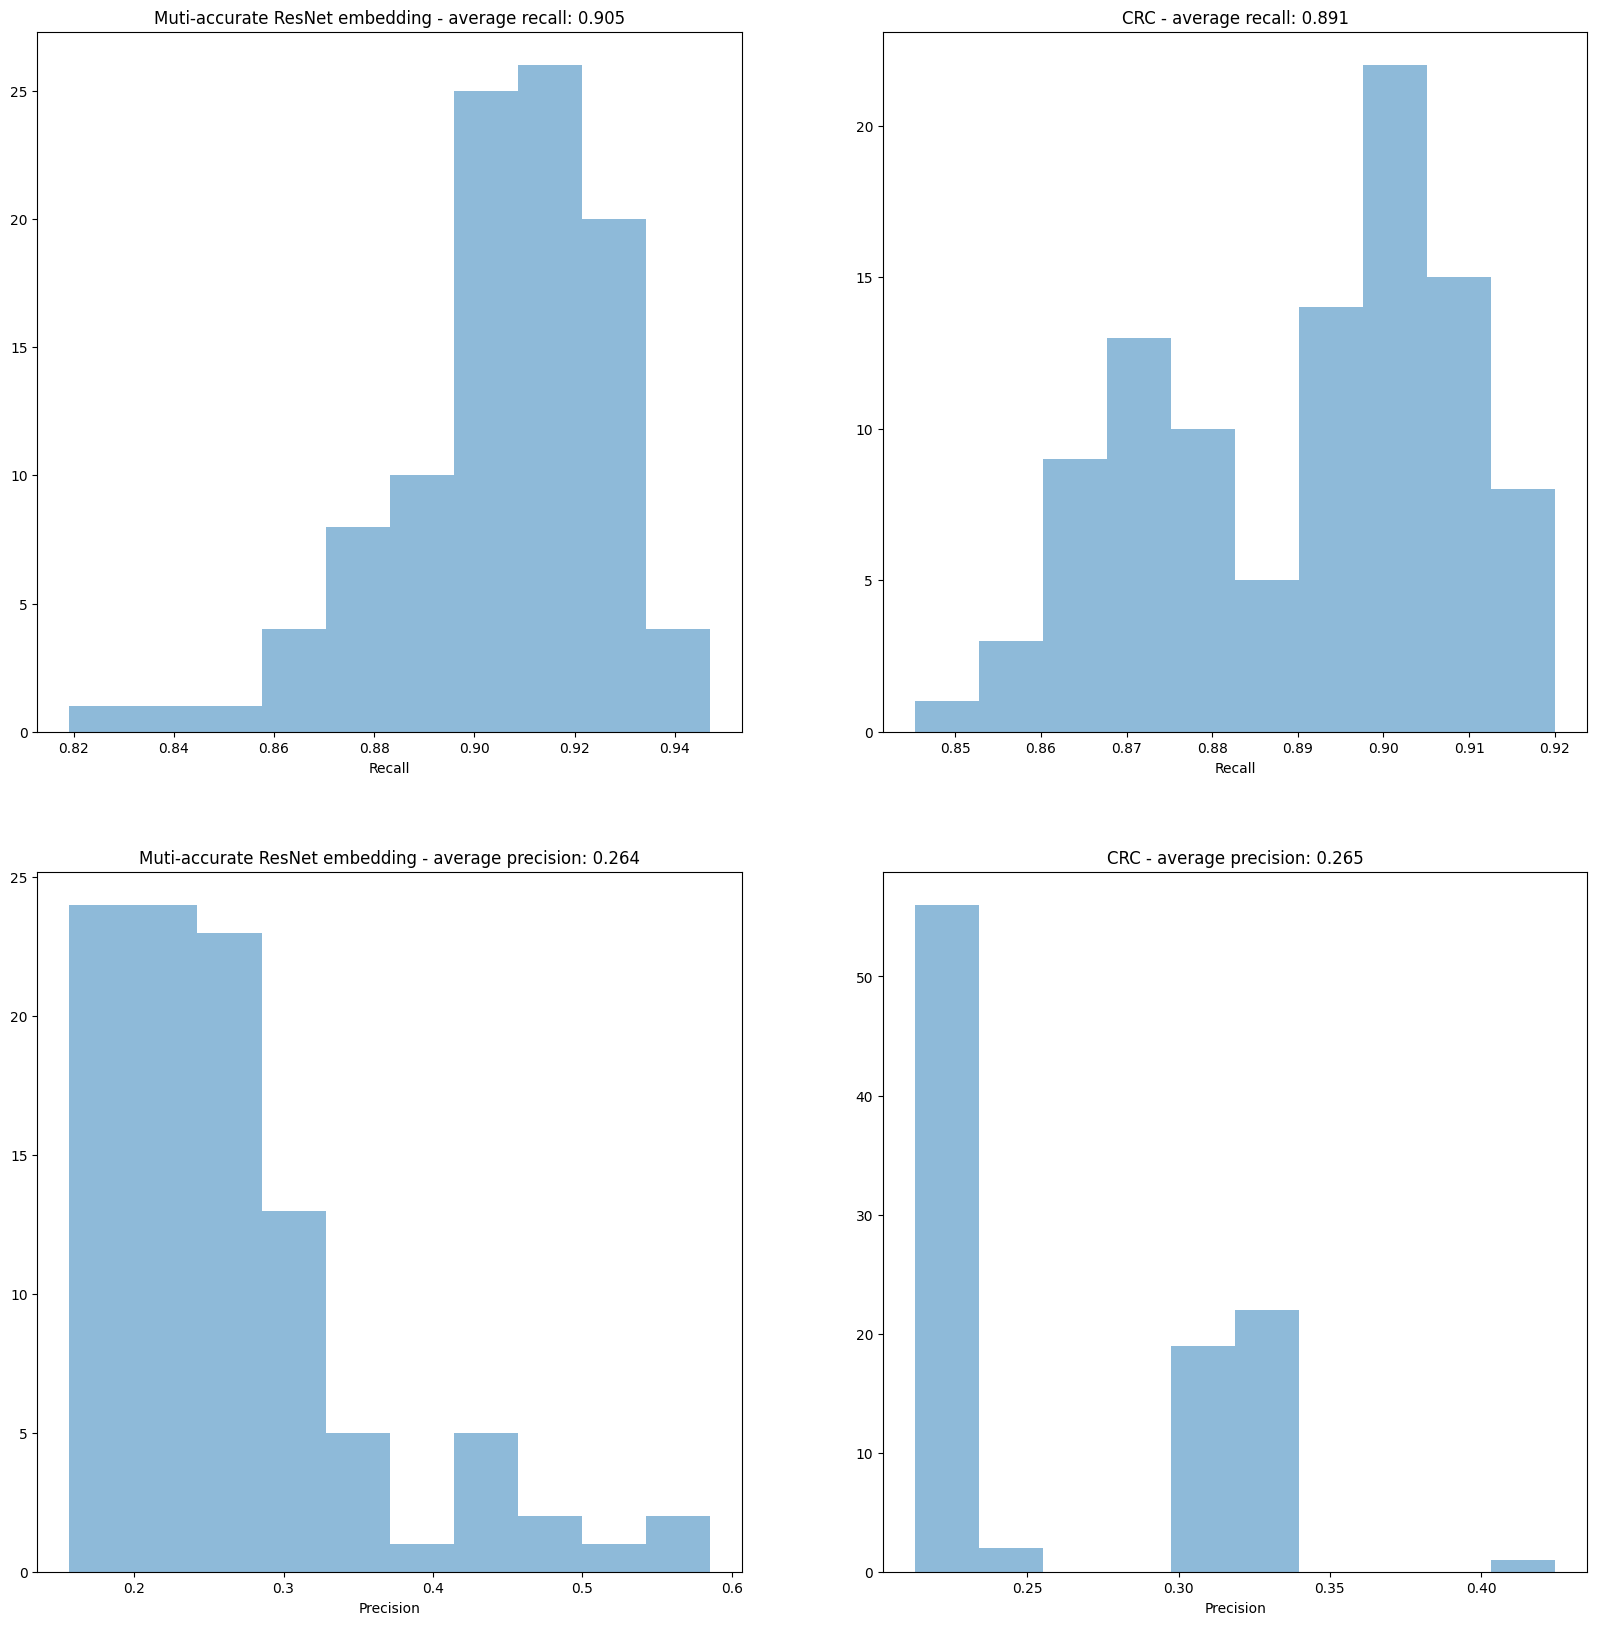

In [16]:
s = 10
nrow = 2
ncol = 2
f, ax = plt.subplots(nrow, ncol, figsize=(ncol * s, nrow * s))


ax[0, 0].hist(recalls_resnet, bins=10, alpha=.5)
ax[0, 0].set_title(f"Muti-accurate ResNet embedding - average recall: {np.nanmean(recalls_resnet):.3f}")
ax[0, 0].set_xlabel("Recall")

ax[0, 1].hist(recalls_crc, bins=10, alpha=.5)
ax[0, 1].set_title(f"CRC - average recall: {np.nanmean(recalls_crc):.3f}")
ax[0, 1].set_xlabel("Recall")

ax[1, 0].hist(precisions_resnet, bins=10, alpha=.5)
ax[1, 0].set_title(f"Muti-accurate ResNet embedding - average precision: {np.nanmean(precisions_resnet):.3f}")
ax[1, 0].set_xlabel("Precision")

ax[1, 1].hist(precisions_crc, bins=10, alpha=.5)
ax[1, 1].set_title(f"CRC - average precision: {np.nanmean(precisions_crc):.3f}")
ax[1, 1].set_xlabel("Precision")